In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

In [4]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

## Non-local block

In [5]:
class NLBlockND(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, inter_channels=None, mode='embedded', 
                 dimension=2, bn_layer=True, **kwargs):
        """Implementation of Non-Local Block with 4 different pairwise functions but doesn't include subsampling trick
        args:
            in_channels: original channel size (1024 in the paper)
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
        """
        super(NLBlockND, self).__init__()

        assert dimension in [1, 2, 3]
        
        if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
            raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')
            
        self.device = kwargs['device']
        self.mode = mode
        self.dimension = dimension

        self.in_channels_1 = in_channels_1
        self.in_channels_2 = in_channels_2
        self.inter_channels = inter_channels

        # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels_2 // 2
            if self.inter_channels == 0:
                self.inter_channels = 1
        
        # assign appropriate convolutional, max pool, and batch norm layers for different dimensions
        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        # function g in the paper which goes through conv. with kernel size 1
        self.g = conv_nd(in_channels=self.in_channels_2, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels_2, kernel_size=1),
                    bn(self.in_channels_2)
                ).to(self.device)
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels_2, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)

        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = nn.Sequential(conv_nd(in_channels=self.in_channels_1, out_channels=self.inter_channels, kernel_size=1),
                                       max_pool_layer).to(self.device)
            self.phi = conv_nd(in_channels=self.in_channels_2, out_channels=self.inter_channels, kernel_size=1)
        
        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                ).to(self.device)
            
    def forward(self, x1, x2):
        """
        args
            x: (N, C, T, H, W) for dimension=3; (N, C, H, W) for dimension 2; (N, C, T) for dimension 1
        """

        batch_size = x1.size(0)
        
        # (N, C, THW)
        # this reshaping and permutation is from the spacetime_nonlocal function in the original Caffe2 implementation
        g_x = self.g(x2).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "gaussian":
            theta_x = x1.view(batch_size, self.in_channels_1, -1)
            phi_x = x2.view(batch_size, self.in_channels_2, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x1).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x2).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x1).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x2).view(batch_size, self.inter_channels, 1, -1)
            
            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)
            
            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))
        
        if self.mode == "gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N
        
        y = torch.matmul(f_div_C, g_x)
        
        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x2.size()[2:])
        
        W_y = self.W_z(y)
        
        # residual connection
        z = W_y + x2

        return z

## ResNet backbone

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        # init weight of batchnorm to 0 to make sure init stage is indenity mapping
        nn.init.constant_(self.bn2_.weight, 0)
        nn.init.constant_(self.bn2_.bias, 0)
        
        nn.init.constant_(self.bn3_.weight, 0)
        nn.init.constant_(self.bn3_.bias, 0)


    def forward(self, x):        
        
        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)

        # 2nd
        x = self.conv2(x1)
        x = self.bn2(x)
        x2 = self.relu(x)
        
        _x2 = x2 + x1
        _x2 = self.bn2_(_x2)
        
        # 3rd
        x = self.conv2(_x2)
        x = self.bn3(x)
        x3 = self.relu(x)
        
        _x3 = x3 + x2
        _x3 = self.bn3_(_x3)

        # maxpooling
        x = self.maxpool(_x3)

        return x

In [7]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)       
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        
        self.nl1 = NLBlockND(64, 128, mode='embedded', device=self.device).to(device)
        self.nl2 = NLBlockND(128, 256, mode='embedded', device=self.device).to(device)
        self.nl3 = NLBlockND(256, 512, mode='embedded', device=self.device).to(device)

        self.fc1 = nn.Linear(512, 7)
#         self.bn1 = nn.BatchNorm1d(512)
#         self.fc2 = nn.Linear(512, 7)
#         self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        
        x0 = self.sv0(x)
        
        x1 = self.sv1(x0)
        x1 = self.nl1(x0, x1)
        
        x2 = self.sv2(x1)
        x2 = self.nl2(x1, x2)
        
        x3 = self.sv3(x2)
        x_out = self.nl3(x2, x3)


        # x_wf1 = nn.AvgPool2d(kernel_size=(x_wf1.size(-2), x_wf1.size(-1)))(x_wf1)
        # x_wf2 = nn.AvgPool2d(kernel_size=(x_wf2.size(-2), x_wf2.size(-1)))(x_wf2)
        x_out = nn.AvgPool2d(kernel_size=(x_out.size(-2), x_out.size(-1)))(x_out)
        # x3 = nn.AvgPool2d(kernel_size=(x3.size(-2), x3.size(-1)))(x3)

        # x = torch.cat([x_wf1, x_wf2, x_wf3, x3], dim=1)
        x = nn.Flatten()(x_out)

        x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.fc2(x)
#         x = self.bn2(x)

        return x

In [8]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


cuda


In [9]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/nonlocal_resnet_1.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 1.947 acc: 0.156
	 - Step 2: loss: 1.947 acc: 0.141
	 - Step 3: loss: 1.941 acc: 0.250
	 - Step 4: loss: 1.938 acc: 0.031
	 - Step 5: loss: 1.933 acc: 0.234
	 - Step 6: loss: 1.921 acc: 0.312
	 - Step 7: loss: 1.914 acc: 0.297
	 - Step 8: loss: 1.910 acc: 0.266
	 - Step 9: loss: 1.911 acc: 0.188
	 - Step 10: loss: 1.906 acc: 0.203
	 - Step 11: loss: 1.925 acc: 0.109
	 - Step 12: loss: 1.890 acc: 0.125
	 - Step 13: loss: 1.869 acc: 0.281
	 - Step 14: loss: 1.879 acc: 0.219
	 - Step 15: loss: 1.862 acc: 0.219
	 - Step 16: loss: 1.828 acc: 0.281
	 - Step 17: loss: 1.842 acc: 0.312
	 - Step 18: loss: 1.914 acc: 0.219
	 - Step 19: loss: 1.818 acc: 0.266
	 - Step 20: loss: 1.859 acc: 0.266
	 - Step 21: loss: 1.849 acc: 0.312
	 - Step 22: loss: 1.877 acc: 0.281
	 - Step 23: loss: 1.872 acc: 0.203
	 - Step 24: loss: 1.813 acc: 0.234
	 - Step 25: loss: 1.845 acc: 0.234
	 - Step 26: loss: 1.780 acc: 0.250
	 - Step 27: loss: 1.807 acc: 0.297
	 - Step 28: loss: 1.825 ac

	 - Step 226: loss: 1.451 acc: 0.359
	 - Step 227: loss: 1.503 acc: 0.391
	 - Step 228: loss: 1.484 acc: 0.406
	 - Step 229: loss: 1.551 acc: 0.375
	 - Step 230: loss: 1.602 acc: 0.391
	 - Step 231: loss: 1.713 acc: 0.312
	 - Step 232: loss: 1.567 acc: 0.328
	 - Step 233: loss: 1.610 acc: 0.375
	 - Step 234: loss: 1.589 acc: 0.266
	 - Step 235: loss: 1.434 acc: 0.469
	 - Step 236: loss: 1.654 acc: 0.328
	 - Step 237: loss: 1.354 acc: 0.469
	 - Step 238: loss: 1.531 acc: 0.344
	 - Step 239: loss: 1.472 acc: 0.438
	 - Step 240: loss: 1.522 acc: 0.359
	 - Step 241: loss: 1.545 acc: 0.375
	 - Step 242: loss: 1.480 acc: 0.391
	 - Step 243: loss: 1.486 acc: 0.469
	 - Step 244: loss: 1.575 acc: 0.375
	 - Step 245: loss: 1.472 acc: 0.344
	 - Step 246: loss: 1.402 acc: 0.391
	 - Step 247: loss: 1.591 acc: 0.438
	 - Step 248: loss: 1.538 acc: 0.375
	 - Step 249: loss: 1.445 acc: 0.406
	 - Step 250: loss: 1.522 acc: 0.438
	 - Step 251: loss: 1.416 acc: 0.375
	 - Step 252: loss: 1.525 acc: 0.422
	

	 - Step 448: loss: 1.482 acc: 0.375
	 - Step 449: loss: 1.507 acc: 0.514
- Avg.loss: 1.558  | Avg.acc: 0.375
- Avg. val_loss: 1.395  | Avg. val_acc: 0.469


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NLBlockND. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.392 acc: 0.438
	 - Step 2: loss: 1.282 acc: 0.531
	 - Step 3: loss: 1.300 acc: 0.453
	 - Step 4: loss: 1.346 acc: 0.531
	 - Step 5: loss: 1.245 acc: 0.469
	 - Step 6: loss: 1.421 acc: 0.469
	 - Step 7: loss: 1.287 acc: 0.500
	 - Step 8: loss: 1.455 acc: 0.469
	 - Step 9: loss: 1.208 acc: 0.500
	 - Step 10: loss: 1.201 acc: 0.547
	 - Step 11: loss: 1.297 acc: 0.484
	 - Step 12: loss: 1.245 acc: 0.484
	 - Step 13: loss: 1.216 acc: 0.547
	 - Step 14: loss: 1.198 acc: 0.516
	 - Step 15: loss: 1.424 acc: 0.422
	 - Step 16: loss: 1.167 acc: 0.578
	 - Step 17: loss: 1.253 acc: 0.547
	 - Step 18: loss: 1.262 acc: 0.531
	 - Step 19: loss: 1.389 acc: 0.500
	 - Step 20: loss: 1.430 acc: 0.453
	 - Step 21: loss: 1.301 acc: 0.453
	 - Step 22: loss: 1.218 acc: 0.453
	 - Step 23: loss: 1.213 acc: 0.516
	 - Step 24: loss: 1.232 acc: 0.469
	 - Step 25: loss: 1.203 acc: 0.578
	 - Step 26: loss: 1.582 acc: 0.422
	 - Step 27: loss: 1.382 acc: 0.438
	 - 

	 - Step 226: loss: 1.243 acc: 0.484
	 - Step 227: loss: 1.304 acc: 0.578
	 - Step 228: loss: 1.130 acc: 0.562
	 - Step 229: loss: 1.276 acc: 0.516
	 - Step 230: loss: 1.249 acc: 0.547
	 - Step 231: loss: 1.233 acc: 0.516
	 - Step 232: loss: 1.129 acc: 0.578
	 - Step 233: loss: 1.053 acc: 0.578
	 - Step 234: loss: 1.444 acc: 0.453
	 - Step 235: loss: 1.164 acc: 0.562
	 - Step 236: loss: 1.135 acc: 0.562
	 - Step 237: loss: 1.131 acc: 0.594
	 - Step 238: loss: 1.253 acc: 0.547
	 - Step 239: loss: 1.286 acc: 0.531
	 - Step 240: loss: 1.198 acc: 0.500
	 - Step 241: loss: 1.159 acc: 0.562
	 - Step 242: loss: 1.221 acc: 0.469
	 - Step 243: loss: 1.302 acc: 0.469
	 - Step 244: loss: 1.323 acc: 0.453
	 - Step 245: loss: 1.154 acc: 0.531
	 - Step 246: loss: 1.301 acc: 0.469
	 - Step 247: loss: 1.394 acc: 0.438
	 - Step 248: loss: 1.388 acc: 0.406
	 - Step 249: loss: 1.117 acc: 0.578
	 - Step 250: loss: 1.207 acc: 0.484
	 - Step 251: loss: 1.239 acc: 0.516
	 - Step 252: loss: 1.474 acc: 0.422
	

	 - Step 448: loss: 1.123 acc: 0.578
	 - Step 449: loss: 1.218 acc: 0.568
- Avg.loss: 1.251  | Avg.acc: 0.517
- Avg. val_loss: 1.272  | Avg. val_acc: 0.510
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.218 acc: 0.453
	 - Step 2: loss: 1.003 acc: 0.594
	 - Step 3: loss: 1.092 acc: 0.625
	 - Step 4: loss: 1.100 acc: 0.531
	 - Step 5: loss: 1.111 acc: 0.531
	 - Step 6: loss: 1.060 acc: 0.578
	 - Step 7: loss: 0.924 acc: 0.656
	 - Step 8: loss: 1.200 acc: 0.609
	 - Step 9: loss: 1.174 acc: 0.547
	 - Step 10: loss: 1.072 acc: 0.562
	 - Step 11: loss: 1.100 acc: 0.641
	 - Step 12: loss: 1.073 acc: 0.531
	 - Step 13: loss: 1.245 acc: 0.469
	 - Step 14: loss: 1.208 acc: 0.516
	 - Step 15: loss: 1.255 acc: 0.531
	 - Step 16: loss: 1.014 acc: 0.641
	 - Step 17: loss: 0.975 acc: 0.594
	 - Step 18: loss: 1.097 acc: 0.547
	 - Step 19: loss: 1.093 acc: 0.562
	 - Step 20: loss: 1.189 acc: 0.453
	 - Step 21: loss: 1.077 acc: 0.469
	 - Step 22: loss: 0.977 acc: 0.609
	 - Step 23: loss: 1.176 acc

	 - Step 223: loss: 1.335 acc: 0.547
	 - Step 224: loss: 1.141 acc: 0.500
	 - Step 225: loss: 1.084 acc: 0.609
	 - Step 226: loss: 1.133 acc: 0.609
	 - Step 227: loss: 1.193 acc: 0.594
	 - Step 228: loss: 1.174 acc: 0.500
	 - Step 229: loss: 1.107 acc: 0.609
	 - Step 230: loss: 1.122 acc: 0.578
	 - Step 231: loss: 1.386 acc: 0.469
	 - Step 232: loss: 1.164 acc: 0.547
	 - Step 233: loss: 1.275 acc: 0.531
	 - Step 234: loss: 1.114 acc: 0.547
	 - Step 235: loss: 1.032 acc: 0.609
	 - Step 236: loss: 1.128 acc: 0.578
	 - Step 237: loss: 1.141 acc: 0.516
	 - Step 238: loss: 1.097 acc: 0.547
	 - Step 239: loss: 1.209 acc: 0.484
	 - Step 240: loss: 1.046 acc: 0.672
	 - Step 241: loss: 1.074 acc: 0.562
	 - Step 242: loss: 1.192 acc: 0.516
	 - Step 243: loss: 1.235 acc: 0.547
	 - Step 244: loss: 1.225 acc: 0.562
	 - Step 245: loss: 1.163 acc: 0.594
	 - Step 246: loss: 1.286 acc: 0.516
	 - Step 247: loss: 1.035 acc: 0.547
	 - Step 248: loss: 1.085 acc: 0.672
	 - Step 249: loss: 1.325 acc: 0.516
	

	 - Step 445: loss: 1.149 acc: 0.562
	 - Step 446: loss: 1.068 acc: 0.609
	 - Step 447: loss: 1.111 acc: 0.562
	 - Step 448: loss: 0.961 acc: 0.625
	 - Step 449: loss: 1.135 acc: 0.541
- Avg.loss: 1.130  | Avg.acc: 0.567
- Avg. val_loss: 1.164  | Avg. val_acc: 0.557
* Update optimal model
Epoch:  4
	 - Step 1: loss: 0.883 acc: 0.594
	 - Step 2: loss: 1.198 acc: 0.500
	 - Step 3: loss: 1.187 acc: 0.531
	 - Step 4: loss: 1.044 acc: 0.672
	 - Step 5: loss: 1.042 acc: 0.625
	 - Step 6: loss: 1.048 acc: 0.594
	 - Step 7: loss: 0.978 acc: 0.688
	 - Step 8: loss: 0.978 acc: 0.609
	 - Step 9: loss: 0.930 acc: 0.609
	 - Step 10: loss: 1.206 acc: 0.484
	 - Step 11: loss: 1.090 acc: 0.594
	 - Step 12: loss: 0.851 acc: 0.719
	 - Step 13: loss: 0.950 acc: 0.703
	 - Step 14: loss: 1.006 acc: 0.625
	 - Step 15: loss: 0.994 acc: 0.578
	 - Step 16: loss: 1.028 acc: 0.625
	 - Step 17: loss: 1.147 acc: 0.625
	 - Step 18: loss: 1.074 acc: 0.562
	 - Step 19: loss: 1.048 acc: 0.594
	 - Step 20: loss: 0.875 

	 - Step 220: loss: 0.994 acc: 0.594
	 - Step 221: loss: 1.056 acc: 0.656
	 - Step 222: loss: 0.983 acc: 0.625
	 - Step 223: loss: 1.026 acc: 0.625
	 - Step 224: loss: 0.966 acc: 0.609
	 - Step 225: loss: 0.841 acc: 0.688
	 - Step 226: loss: 0.999 acc: 0.594
	 - Step 227: loss: 0.798 acc: 0.719
	 - Step 228: loss: 0.979 acc: 0.641
	 - Step 229: loss: 0.979 acc: 0.594
	 - Step 230: loss: 1.080 acc: 0.578
	 - Step 231: loss: 0.963 acc: 0.625
	 - Step 232: loss: 0.748 acc: 0.766
	 - Step 233: loss: 0.972 acc: 0.656
	 - Step 234: loss: 0.998 acc: 0.641
	 - Step 235: loss: 1.027 acc: 0.578
	 - Step 236: loss: 1.143 acc: 0.594
	 - Step 237: loss: 0.900 acc: 0.703
	 - Step 238: loss: 0.978 acc: 0.594
	 - Step 239: loss: 0.979 acc: 0.656
	 - Step 240: loss: 1.040 acc: 0.688
	 - Step 241: loss: 0.997 acc: 0.609
	 - Step 242: loss: 1.009 acc: 0.609
	 - Step 243: loss: 0.998 acc: 0.609
	 - Step 244: loss: 0.926 acc: 0.578
	 - Step 245: loss: 1.168 acc: 0.578
	 - Step 246: loss: 0.912 acc: 0.625
	

	 - Step 442: loss: 0.969 acc: 0.578
	 - Step 443: loss: 1.250 acc: 0.578
	 - Step 444: loss: 1.029 acc: 0.641
	 - Step 445: loss: 0.824 acc: 0.672
	 - Step 446: loss: 1.184 acc: 0.562
	 - Step 447: loss: 0.970 acc: 0.641
	 - Step 448: loss: 0.975 acc: 0.703
	 - Step 449: loss: 1.112 acc: 0.541
- Avg.loss: 1.028  | Avg.acc: 0.609
- Avg. val_loss: 1.115  | Avg. val_acc: 0.578
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.102 acc: 0.609
	 - Step 2: loss: 0.912 acc: 0.594
	 - Step 3: loss: 0.890 acc: 0.719
	 - Step 4: loss: 0.977 acc: 0.656
	 - Step 5: loss: 0.970 acc: 0.594
	 - Step 6: loss: 0.821 acc: 0.734
	 - Step 7: loss: 0.975 acc: 0.625
	 - Step 8: loss: 1.001 acc: 0.609
	 - Step 9: loss: 1.005 acc: 0.609
	 - Step 10: loss: 1.010 acc: 0.641
	 - Step 11: loss: 0.684 acc: 0.797
	 - Step 12: loss: 0.970 acc: 0.656
	 - Step 13: loss: 0.886 acc: 0.641
	 - Step 14: loss: 0.909 acc: 0.688
	 - Step 15: loss: 0.985 acc: 0.578
	 - Step 16: loss: 1.021 acc: 0.578
	 - Step 17: loss: 1.0

	 - Step 217: loss: 0.712 acc: 0.750
	 - Step 218: loss: 1.016 acc: 0.578
	 - Step 219: loss: 0.932 acc: 0.703
	 - Step 220: loss: 0.995 acc: 0.594
	 - Step 221: loss: 0.987 acc: 0.672
	 - Step 222: loss: 0.970 acc: 0.625
	 - Step 223: loss: 1.106 acc: 0.641
	 - Step 224: loss: 0.883 acc: 0.719
	 - Step 225: loss: 1.001 acc: 0.656
	 - Step 226: loss: 1.051 acc: 0.609
	 - Step 227: loss: 0.945 acc: 0.625
	 - Step 228: loss: 0.874 acc: 0.672
	 - Step 229: loss: 0.825 acc: 0.688
	 - Step 230: loss: 0.982 acc: 0.688
	 - Step 231: loss: 1.076 acc: 0.578
	 - Step 232: loss: 1.011 acc: 0.641
	 - Step 233: loss: 0.903 acc: 0.641
	 - Step 234: loss: 0.978 acc: 0.656
	 - Step 235: loss: 0.910 acc: 0.641
	 - Step 236: loss: 0.850 acc: 0.672
	 - Step 237: loss: 1.102 acc: 0.578
	 - Step 238: loss: 0.841 acc: 0.703
	 - Step 239: loss: 1.085 acc: 0.688
	 - Step 240: loss: 1.030 acc: 0.531
	 - Step 241: loss: 0.929 acc: 0.594
	 - Step 242: loss: 0.850 acc: 0.734
	 - Step 243: loss: 1.045 acc: 0.594
	

	 - Step 439: loss: 1.008 acc: 0.719
	 - Step 440: loss: 0.970 acc: 0.609
	 - Step 441: loss: 0.854 acc: 0.688
	 - Step 442: loss: 0.920 acc: 0.609
	 - Step 443: loss: 0.961 acc: 0.656
	 - Step 444: loss: 1.151 acc: 0.594
	 - Step 445: loss: 1.051 acc: 0.688
	 - Step 446: loss: 0.907 acc: 0.703
	 - Step 447: loss: 0.990 acc: 0.625
	 - Step 448: loss: 0.840 acc: 0.719
	 - Step 449: loss: 0.790 acc: 0.622
- Avg.loss: 0.943  | Avg.acc: 0.647
- Avg. val_loss: 1.059  | Avg. val_acc: 0.603
* Update optimal model
Epoch:  6
	 - Step 1: loss: 0.648 acc: 0.812
	 - Step 2: loss: 1.011 acc: 0.609
	 - Step 3: loss: 0.910 acc: 0.703
	 - Step 4: loss: 0.877 acc: 0.656
	 - Step 5: loss: 0.860 acc: 0.688
	 - Step 6: loss: 0.759 acc: 0.734
	 - Step 7: loss: 1.004 acc: 0.625
	 - Step 8: loss: 0.945 acc: 0.609
	 - Step 9: loss: 0.833 acc: 0.656
	 - Step 10: loss: 0.973 acc: 0.594
	 - Step 11: loss: 0.751 acc: 0.719
	 - Step 12: loss: 0.677 acc: 0.750
	 - Step 13: loss: 0.873 acc: 0.656
	 - Step 14: loss: 

	 - Step 214: loss: 1.023 acc: 0.641
	 - Step 215: loss: 0.835 acc: 0.672
	 - Step 216: loss: 1.043 acc: 0.578
	 - Step 217: loss: 0.996 acc: 0.656
	 - Step 218: loss: 1.082 acc: 0.656
	 - Step 219: loss: 0.925 acc: 0.656
	 - Step 220: loss: 0.761 acc: 0.734
	 - Step 221: loss: 0.839 acc: 0.703
	 - Step 222: loss: 0.926 acc: 0.672
	 - Step 223: loss: 0.866 acc: 0.625
	 - Step 224: loss: 0.900 acc: 0.625
	 - Step 225: loss: 1.102 acc: 0.531
	 - Step 226: loss: 0.966 acc: 0.547
	 - Step 227: loss: 0.907 acc: 0.625
	 - Step 228: loss: 0.740 acc: 0.734
	 - Step 229: loss: 0.955 acc: 0.703
	 - Step 230: loss: 0.900 acc: 0.688
	 - Step 231: loss: 0.799 acc: 0.766
	 - Step 232: loss: 0.907 acc: 0.625
	 - Step 233: loss: 0.745 acc: 0.719
	 - Step 234: loss: 0.912 acc: 0.641
	 - Step 235: loss: 0.847 acc: 0.672
	 - Step 236: loss: 0.863 acc: 0.641
	 - Step 237: loss: 0.767 acc: 0.766
	 - Step 238: loss: 0.787 acc: 0.672
	 - Step 239: loss: 1.176 acc: 0.547
	 - Step 240: loss: 0.796 acc: 0.672
	

	 - Step 436: loss: 0.814 acc: 0.734
	 - Step 437: loss: 0.851 acc: 0.609
	 - Step 438: loss: 1.073 acc: 0.641
	 - Step 439: loss: 0.918 acc: 0.656
	 - Step 440: loss: 0.902 acc: 0.594
	 - Step 441: loss: 0.769 acc: 0.641
	 - Step 442: loss: 0.815 acc: 0.625
	 - Step 443: loss: 0.795 acc: 0.703
	 - Step 444: loss: 1.036 acc: 0.625
	 - Step 445: loss: 0.996 acc: 0.641
	 - Step 446: loss: 1.073 acc: 0.625
	 - Step 447: loss: 0.937 acc: 0.641
	 - Step 448: loss: 0.875 acc: 0.719
	 - Step 449: loss: 0.996 acc: 0.622
- Avg.loss: 0.859  | Avg.acc: 0.678
- Avg. val_loss: 1.120  | Avg. val_acc: 0.597
Epoch:  7
	 - Step 1: loss: 0.697 acc: 0.719
	 - Step 2: loss: 0.747 acc: 0.750
	 - Step 3: loss: 0.591 acc: 0.828
	 - Step 4: loss: 0.768 acc: 0.719
	 - Step 5: loss: 0.680 acc: 0.781
	 - Step 6: loss: 0.974 acc: 0.656
	 - Step 7: loss: 0.869 acc: 0.672
	 - Step 8: loss: 0.798 acc: 0.672
	 - Step 9: loss: 0.753 acc: 0.766
	 - Step 10: loss: 0.754 acc: 0.719
	 - Step 11: loss: 0.951 acc: 0.609
	 -

	 - Step 211: loss: 0.763 acc: 0.703
	 - Step 212: loss: 0.548 acc: 0.750
	 - Step 213: loss: 0.793 acc: 0.734
	 - Step 214: loss: 0.616 acc: 0.781
	 - Step 215: loss: 0.796 acc: 0.719
	 - Step 216: loss: 0.743 acc: 0.734
	 - Step 217: loss: 0.567 acc: 0.797
	 - Step 218: loss: 0.542 acc: 0.844
	 - Step 219: loss: 0.901 acc: 0.656
	 - Step 220: loss: 0.726 acc: 0.719
	 - Step 221: loss: 0.944 acc: 0.656
	 - Step 222: loss: 0.622 acc: 0.766
	 - Step 223: loss: 0.765 acc: 0.734
	 - Step 224: loss: 0.667 acc: 0.781
	 - Step 225: loss: 0.745 acc: 0.750
	 - Step 226: loss: 0.694 acc: 0.734
	 - Step 227: loss: 0.620 acc: 0.781
	 - Step 228: loss: 0.888 acc: 0.656
	 - Step 229: loss: 0.921 acc: 0.656
	 - Step 230: loss: 0.749 acc: 0.688
	 - Step 231: loss: 0.829 acc: 0.703
	 - Step 232: loss: 0.769 acc: 0.672
	 - Step 233: loss: 0.670 acc: 0.703
	 - Step 234: loss: 0.619 acc: 0.797
	 - Step 235: loss: 0.632 acc: 0.781
	 - Step 236: loss: 0.974 acc: 0.656
	 - Step 237: loss: 0.746 acc: 0.703
	

	 - Step 433: loss: 0.863 acc: 0.719
	 - Step 434: loss: 0.805 acc: 0.641
	 - Step 435: loss: 1.153 acc: 0.625
	 - Step 436: loss: 0.646 acc: 0.797
	 - Step 437: loss: 0.724 acc: 0.766
	 - Step 438: loss: 0.931 acc: 0.734
	 - Step 439: loss: 0.920 acc: 0.672
	 - Step 440: loss: 0.934 acc: 0.656
	 - Step 441: loss: 0.913 acc: 0.609
	 - Step 442: loss: 0.825 acc: 0.719
	 - Step 443: loss: 0.775 acc: 0.703
	 - Step 444: loss: 0.777 acc: 0.688
	 - Step 445: loss: 0.618 acc: 0.828
	 - Step 446: loss: 0.679 acc: 0.750
	 - Step 447: loss: 0.834 acc: 0.734
	 - Step 448: loss: 0.881 acc: 0.719
	 - Step 449: loss: 0.684 acc: 0.703
- Avg.loss: 0.775  | Avg.acc: 0.708
- Avg. val_loss: 1.070  | Avg. val_acc: 0.614
* Update optimal model
Epoch:  8
	 - Step 1: loss: 0.642 acc: 0.719
	 - Step 2: loss: 0.678 acc: 0.719
	 - Step 3: loss: 0.531 acc: 0.781
	 - Step 4: loss: 0.631 acc: 0.734
	 - Step 5: loss: 0.631 acc: 0.766
	 - Step 6: loss: 0.615 acc: 0.812
	 - Step 7: loss: 0.517 acc: 0.844
	 - Step 8:

	 - Step 208: loss: 0.705 acc: 0.766
	 - Step 209: loss: 0.566 acc: 0.781
	 - Step 210: loss: 0.677 acc: 0.719
	 - Step 211: loss: 0.661 acc: 0.703
	 - Step 212: loss: 0.680 acc: 0.672
	 - Step 213: loss: 0.688 acc: 0.719
	 - Step 214: loss: 0.602 acc: 0.750
	 - Step 215: loss: 0.608 acc: 0.781
	 - Step 216: loss: 0.786 acc: 0.734
	 - Step 217: loss: 0.637 acc: 0.781
	 - Step 218: loss: 0.566 acc: 0.750
	 - Step 219: loss: 0.679 acc: 0.766
	 - Step 220: loss: 0.540 acc: 0.797
	 - Step 221: loss: 0.669 acc: 0.766
	 - Step 222: loss: 0.826 acc: 0.719
	 - Step 223: loss: 0.603 acc: 0.828
	 - Step 224: loss: 0.534 acc: 0.828
	 - Step 225: loss: 0.507 acc: 0.766
	 - Step 226: loss: 0.704 acc: 0.703
	 - Step 227: loss: 0.724 acc: 0.750
	 - Step 228: loss: 0.817 acc: 0.703
	 - Step 229: loss: 0.849 acc: 0.672
	 - Step 230: loss: 0.650 acc: 0.766
	 - Step 231: loss: 0.673 acc: 0.719
	 - Step 232: loss: 0.736 acc: 0.734
	 - Step 233: loss: 0.696 acc: 0.719
	 - Step 234: loss: 0.828 acc: 0.719
	

	 - Step 430: loss: 0.764 acc: 0.688
	 - Step 431: loss: 0.507 acc: 0.797
	 - Step 432: loss: 0.532 acc: 0.797
	 - Step 433: loss: 0.653 acc: 0.750
	 - Step 434: loss: 0.612 acc: 0.781
	 - Step 435: loss: 0.657 acc: 0.797
	 - Step 436: loss: 1.024 acc: 0.547
	 - Step 437: loss: 0.637 acc: 0.750
	 - Step 438: loss: 0.780 acc: 0.656
	 - Step 439: loss: 0.844 acc: 0.719
	 - Step 440: loss: 0.729 acc: 0.688
	 - Step 441: loss: 0.842 acc: 0.688
	 - Step 442: loss: 0.890 acc: 0.656
	 - Step 443: loss: 0.916 acc: 0.594
	 - Step 444: loss: 0.777 acc: 0.672
	 - Step 445: loss: 0.791 acc: 0.672
	 - Step 446: loss: 0.546 acc: 0.828
	 - Step 447: loss: 0.591 acc: 0.750
	 - Step 448: loss: 0.836 acc: 0.734
	 - Step 449: loss: 0.714 acc: 0.649
- Avg.loss: 0.683  | Avg.acc: 0.745
- Avg. val_loss: 1.235  | Avg. val_acc: 0.581
Epoch:  9
	 - Step 1: loss: 0.526 acc: 0.828
	 - Step 2: loss: 0.728 acc: 0.656
	 - Step 3: loss: 0.527 acc: 0.766
	 - Step 4: loss: 0.410 acc: 0.859
	 - Step 5: loss: 0.554 acc:

	 - Step 205: loss: 0.388 acc: 0.875
	 - Step 206: loss: 0.627 acc: 0.719
	 - Step 207: loss: 0.643 acc: 0.672
	 - Step 208: loss: 0.737 acc: 0.703
	 - Step 209: loss: 0.683 acc: 0.766
	 - Step 210: loss: 0.651 acc: 0.688
	 - Step 211: loss: 0.773 acc: 0.672
	 - Step 212: loss: 0.839 acc: 0.672
	 - Step 213: loss: 0.617 acc: 0.781
	 - Step 214: loss: 0.788 acc: 0.766
	 - Step 215: loss: 0.361 acc: 0.891
	 - Step 216: loss: 0.523 acc: 0.812
	 - Step 217: loss: 0.651 acc: 0.781
	 - Step 218: loss: 0.472 acc: 0.859
	 - Step 219: loss: 0.821 acc: 0.688
	 - Step 220: loss: 0.782 acc: 0.656
	 - Step 221: loss: 0.636 acc: 0.766
	 - Step 222: loss: 0.656 acc: 0.719
	 - Step 223: loss: 0.659 acc: 0.719
	 - Step 224: loss: 0.819 acc: 0.656
	 - Step 225: loss: 0.557 acc: 0.797
	 - Step 226: loss: 0.617 acc: 0.781
	 - Step 227: loss: 0.581 acc: 0.766
	 - Step 228: loss: 0.524 acc: 0.844
	 - Step 229: loss: 0.665 acc: 0.766
	 - Step 230: loss: 0.422 acc: 0.859
	 - Step 231: loss: 0.596 acc: 0.766
	

	 - Step 427: loss: 0.705 acc: 0.719
	 - Step 428: loss: 0.530 acc: 0.797
	 - Step 429: loss: 0.696 acc: 0.719
	 - Step 430: loss: 0.571 acc: 0.812
	 - Step 431: loss: 0.711 acc: 0.781
	 - Step 432: loss: 0.424 acc: 0.906
	 - Step 433: loss: 0.514 acc: 0.844
	 - Step 434: loss: 0.615 acc: 0.750
	 - Step 435: loss: 0.532 acc: 0.844
	 - Step 436: loss: 0.600 acc: 0.828
	 - Step 437: loss: 0.712 acc: 0.719
	 - Step 438: loss: 0.494 acc: 0.828
	 - Step 439: loss: 0.554 acc: 0.766
	 - Step 440: loss: 0.706 acc: 0.703
	 - Step 441: loss: 0.484 acc: 0.828
	 - Step 442: loss: 0.687 acc: 0.734
	 - Step 443: loss: 0.618 acc: 0.812
	 - Step 444: loss: 0.573 acc: 0.797
	 - Step 445: loss: 0.603 acc: 0.766
	 - Step 446: loss: 0.457 acc: 0.891
	 - Step 447: loss: 0.542 acc: 0.812
	 - Step 448: loss: 0.729 acc: 0.734
	 - Step 449: loss: 0.750 acc: 0.703
- Avg.loss: 0.574  | Avg.acc: 0.790
- Avg. val_loss: 1.229  | Avg. val_acc: 0.614
Epoch:  10
	 - Step 1: loss: 0.410 acc: 0.844
	 - Step 2: loss: 0.3

	 - Step 202: loss: 0.644 acc: 0.797
	 - Step 203: loss: 0.475 acc: 0.828
	 - Step 204: loss: 0.430 acc: 0.797
	 - Step 205: loss: 0.407 acc: 0.906
	 - Step 206: loss: 0.354 acc: 0.859
	 - Step 207: loss: 0.523 acc: 0.797
	 - Step 208: loss: 0.436 acc: 0.844
	 - Step 209: loss: 0.623 acc: 0.734
	 - Step 210: loss: 0.406 acc: 0.828
	 - Step 211: loss: 0.327 acc: 0.891
	 - Step 212: loss: 0.407 acc: 0.875
	 - Step 213: loss: 0.554 acc: 0.781
	 - Step 214: loss: 0.410 acc: 0.875
	 - Step 215: loss: 0.562 acc: 0.859
	 - Step 216: loss: 0.512 acc: 0.812
	 - Step 217: loss: 0.439 acc: 0.812
	 - Step 218: loss: 0.386 acc: 0.844
	 - Step 219: loss: 0.410 acc: 0.797
	 - Step 220: loss: 0.583 acc: 0.734
	 - Step 221: loss: 0.540 acc: 0.828
	 - Step 222: loss: 0.584 acc: 0.781
	 - Step 223: loss: 0.356 acc: 0.891
	 - Step 224: loss: 0.383 acc: 0.906
	 - Step 225: loss: 0.575 acc: 0.750
	 - Step 226: loss: 0.454 acc: 0.812
	 - Step 227: loss: 0.276 acc: 0.859
	 - Step 228: loss: 0.446 acc: 0.828
	

	 - Step 424: loss: 0.383 acc: 0.859
	 - Step 425: loss: 0.384 acc: 0.859
	 - Step 426: loss: 0.552 acc: 0.781
	 - Step 427: loss: 0.382 acc: 0.891
	 - Step 428: loss: 0.403 acc: 0.828
	 - Step 429: loss: 0.560 acc: 0.797
	 - Step 430: loss: 0.499 acc: 0.781
	 - Step 431: loss: 0.227 acc: 0.922
	 - Step 432: loss: 0.843 acc: 0.672
	 - Step 433: loss: 0.440 acc: 0.812
	 - Step 434: loss: 0.405 acc: 0.859
	 - Step 435: loss: 0.372 acc: 0.891
	 - Step 436: loss: 0.424 acc: 0.844
	 - Step 437: loss: 0.537 acc: 0.828
	 - Step 438: loss: 0.798 acc: 0.703
	 - Step 439: loss: 0.386 acc: 0.828
	 - Step 440: loss: 0.638 acc: 0.781
	 - Step 441: loss: 0.449 acc: 0.828
	 - Step 442: loss: 0.410 acc: 0.859
	 - Step 443: loss: 0.530 acc: 0.781
	 - Step 444: loss: 0.441 acc: 0.859
	 - Step 445: loss: 0.440 acc: 0.844
	 - Step 446: loss: 0.550 acc: 0.766
	 - Step 447: loss: 0.437 acc: 0.828
	 - Step 448: loss: 0.485 acc: 0.906
	 - Step 449: loss: 0.495 acc: 0.730
- Avg.loss: 0.460  | Avg.acc: 0.832
- 

	 - Step 199: loss: 0.313 acc: 0.906
	 - Step 200: loss: 0.424 acc: 0.844
	 - Step 201: loss: 0.320 acc: 0.844
	 - Step 202: loss: 0.607 acc: 0.766
	 - Step 203: loss: 0.232 acc: 0.891
	 - Step 204: loss: 0.350 acc: 0.844
	 - Step 205: loss: 0.350 acc: 0.875
	 - Step 206: loss: 0.354 acc: 0.875
	 - Step 207: loss: 0.265 acc: 0.922
	 - Step 208: loss: 0.367 acc: 0.891
	 - Step 209: loss: 0.404 acc: 0.828
	 - Step 210: loss: 0.319 acc: 0.891
	 - Step 211: loss: 0.400 acc: 0.844
	 - Step 212: loss: 0.515 acc: 0.781
	 - Step 213: loss: 0.425 acc: 0.844
	 - Step 214: loss: 0.369 acc: 0.891
	 - Step 215: loss: 0.620 acc: 0.672
	 - Step 216: loss: 0.514 acc: 0.797
	 - Step 217: loss: 0.490 acc: 0.781
	 - Step 218: loss: 0.336 acc: 0.875
	 - Step 219: loss: 0.342 acc: 0.859
	 - Step 220: loss: 0.414 acc: 0.859
	 - Step 221: loss: 0.451 acc: 0.859
	 - Step 222: loss: 0.365 acc: 0.875
	 - Step 223: loss: 0.436 acc: 0.797
	 - Step 224: loss: 0.303 acc: 0.891
	 - Step 225: loss: 0.355 acc: 0.844
	

	 - Step 421: loss: 0.345 acc: 0.859
	 - Step 422: loss: 0.294 acc: 0.891
	 - Step 423: loss: 0.291 acc: 0.891
	 - Step 424: loss: 0.601 acc: 0.766
	 - Step 425: loss: 0.395 acc: 0.859
	 - Step 426: loss: 0.342 acc: 0.875
	 - Step 427: loss: 0.384 acc: 0.844
	 - Step 428: loss: 0.368 acc: 0.844
	 - Step 429: loss: 0.168 acc: 0.969
	 - Step 430: loss: 0.298 acc: 0.891
	 - Step 431: loss: 0.367 acc: 0.938
	 - Step 432: loss: 0.325 acc: 0.891
	 - Step 433: loss: 0.344 acc: 0.859
	 - Step 434: loss: 0.413 acc: 0.875
	 - Step 435: loss: 0.446 acc: 0.812
	 - Step 436: loss: 0.379 acc: 0.859
	 - Step 437: loss: 0.574 acc: 0.781
	 - Step 438: loss: 0.512 acc: 0.797
	 - Step 439: loss: 0.459 acc: 0.844
	 - Step 440: loss: 0.388 acc: 0.859
	 - Step 441: loss: 0.627 acc: 0.766
	 - Step 442: loss: 0.391 acc: 0.828
	 - Step 443: loss: 0.362 acc: 0.875
	 - Step 444: loss: 0.370 acc: 0.828
	 - Step 445: loss: 0.619 acc: 0.797
	 - Step 446: loss: 0.376 acc: 0.828
	 - Step 447: loss: 0.373 acc: 0.891
	

	 - Step 196: loss: 0.258 acc: 0.906
	 - Step 197: loss: 0.185 acc: 0.938
	 - Step 198: loss: 0.206 acc: 0.938
	 - Step 199: loss: 0.227 acc: 0.906
	 - Step 200: loss: 0.226 acc: 0.922
	 - Step 201: loss: 0.310 acc: 0.875
	 - Step 202: loss: 0.275 acc: 0.922
	 - Step 203: loss: 0.194 acc: 0.938
	 - Step 204: loss: 0.305 acc: 0.891
	 - Step 205: loss: 0.281 acc: 0.875
	 - Step 206: loss: 0.215 acc: 0.938
	 - Step 207: loss: 0.163 acc: 0.938
	 - Step 208: loss: 0.173 acc: 0.938
	 - Step 209: loss: 0.262 acc: 0.922
	 - Step 210: loss: 0.401 acc: 0.875
	 - Step 211: loss: 0.127 acc: 0.969
	 - Step 212: loss: 0.295 acc: 0.906
	 - Step 213: loss: 0.412 acc: 0.828
	 - Step 214: loss: 0.264 acc: 0.891
	 - Step 215: loss: 0.430 acc: 0.906
	 - Step 216: loss: 0.209 acc: 0.875
	 - Step 217: loss: 0.323 acc: 0.891
	 - Step 218: loss: 0.417 acc: 0.812
	 - Step 219: loss: 0.297 acc: 0.891
	 - Step 220: loss: 0.221 acc: 0.922
	 - Step 221: loss: 0.260 acc: 0.906
	 - Step 222: loss: 0.210 acc: 0.906
	

	 - Step 418: loss: 0.281 acc: 0.891
	 - Step 419: loss: 0.262 acc: 0.922
	 - Step 420: loss: 0.292 acc: 0.906
	 - Step 421: loss: 0.513 acc: 0.812
	 - Step 422: loss: 0.361 acc: 0.812
	 - Step 423: loss: 0.412 acc: 0.797
	 - Step 424: loss: 0.298 acc: 0.875
	 - Step 425: loss: 0.290 acc: 0.875
	 - Step 426: loss: 0.333 acc: 0.938
	 - Step 427: loss: 0.365 acc: 0.891
	 - Step 428: loss: 0.452 acc: 0.828
	 - Step 429: loss: 0.417 acc: 0.859
	 - Step 430: loss: 0.319 acc: 0.859
	 - Step 431: loss: 0.184 acc: 0.953
	 - Step 432: loss: 0.332 acc: 0.828
	 - Step 433: loss: 0.195 acc: 0.906
	 - Step 434: loss: 0.169 acc: 0.938
	 - Step 435: loss: 0.320 acc: 0.891
	 - Step 436: loss: 0.276 acc: 0.875
	 - Step 437: loss: 0.297 acc: 0.875
	 - Step 438: loss: 0.462 acc: 0.844
	 - Step 439: loss: 0.296 acc: 0.859
	 - Step 440: loss: 0.397 acc: 0.875
	 - Step 441: loss: 0.361 acc: 0.844
	 - Step 442: loss: 0.381 acc: 0.859
	 - Step 443: loss: 0.260 acc: 0.891
	 - Step 444: loss: 0.514 acc: 0.906
	

	 - Step 193: loss: 0.233 acc: 0.938
	 - Step 194: loss: 0.130 acc: 0.953
	 - Step 195: loss: 0.112 acc: 0.953
	 - Step 196: loss: 0.115 acc: 0.953
	 - Step 197: loss: 0.187 acc: 0.938
	 - Step 198: loss: 0.224 acc: 0.922
	 - Step 199: loss: 0.076 acc: 0.969
	 - Step 200: loss: 0.259 acc: 0.906
	 - Step 201: loss: 0.055 acc: 1.000
	 - Step 202: loss: 0.257 acc: 0.922
	 - Step 203: loss: 0.120 acc: 0.938
	 - Step 204: loss: 0.275 acc: 0.938
	 - Step 205: loss: 0.108 acc: 0.969
	 - Step 206: loss: 0.147 acc: 0.938
	 - Step 207: loss: 0.195 acc: 0.922
	 - Step 208: loss: 0.152 acc: 0.969
	 - Step 209: loss: 0.100 acc: 0.984
	 - Step 210: loss: 0.203 acc: 0.906
	 - Step 211: loss: 0.170 acc: 0.922
	 - Step 212: loss: 0.374 acc: 0.875
	 - Step 213: loss: 0.230 acc: 0.922
	 - Step 214: loss: 0.144 acc: 0.953
	 - Step 215: loss: 0.150 acc: 0.969
	 - Step 216: loss: 0.237 acc: 0.938
	 - Step 217: loss: 0.280 acc: 0.891
	 - Step 218: loss: 0.151 acc: 0.953
	 - Step 219: loss: 0.119 acc: 0.938
	

	 - Step 415: loss: 0.218 acc: 0.938
	 - Step 416: loss: 0.342 acc: 0.859
	 - Step 417: loss: 0.272 acc: 0.922
	 - Step 418: loss: 0.320 acc: 0.891
	 - Step 419: loss: 0.126 acc: 1.000
	 - Step 420: loss: 0.197 acc: 0.906
	 - Step 421: loss: 0.311 acc: 0.922
	 - Step 422: loss: 0.268 acc: 0.938
	 - Step 423: loss: 0.240 acc: 0.891
	 - Step 424: loss: 0.269 acc: 0.891
	 - Step 425: loss: 0.374 acc: 0.844
	 - Step 426: loss: 0.528 acc: 0.859
	 - Step 427: loss: 0.307 acc: 0.875
	 - Step 428: loss: 0.390 acc: 0.828
	 - Step 429: loss: 0.307 acc: 0.891
	 - Step 430: loss: 0.312 acc: 0.906
	 - Step 431: loss: 0.306 acc: 0.891
	 - Step 432: loss: 0.204 acc: 0.938
	 - Step 433: loss: 0.185 acc: 0.922
	 - Step 434: loss: 0.180 acc: 0.953
	 - Step 435: loss: 0.186 acc: 0.906
	 - Step 436: loss: 0.262 acc: 0.891
	 - Step 437: loss: 0.306 acc: 0.875
	 - Step 438: loss: 0.416 acc: 0.859
	 - Step 439: loss: 0.205 acc: 0.922
	 - Step 440: loss: 0.166 acc: 0.906
	 - Step 441: loss: 0.132 acc: 0.953
	

	 - Step 190: loss: 0.167 acc: 0.938
	 - Step 191: loss: 0.244 acc: 0.906
	 - Step 192: loss: 0.098 acc: 0.969
	 - Step 193: loss: 0.318 acc: 0.875
	 - Step 194: loss: 0.154 acc: 0.953
	 - Step 195: loss: 0.173 acc: 0.953
	 - Step 196: loss: 0.101 acc: 0.969
	 - Step 197: loss: 0.090 acc: 0.969
	 - Step 198: loss: 0.182 acc: 0.938
	 - Step 199: loss: 0.245 acc: 0.938
	 - Step 200: loss: 0.056 acc: 1.000
	 - Step 201: loss: 0.160 acc: 0.953
	 - Step 202: loss: 0.149 acc: 0.969
	 - Step 203: loss: 0.153 acc: 0.922
	 - Step 204: loss: 0.177 acc: 0.938
	 - Step 205: loss: 0.214 acc: 0.938
	 - Step 206: loss: 0.064 acc: 0.969
	 - Step 207: loss: 0.133 acc: 0.953
	 - Step 208: loss: 0.061 acc: 0.984
	 - Step 209: loss: 0.138 acc: 0.922
	 - Step 210: loss: 0.142 acc: 0.938
	 - Step 211: loss: 0.096 acc: 0.969
	 - Step 212: loss: 0.239 acc: 0.891
	 - Step 213: loss: 0.204 acc: 0.906
	 - Step 214: loss: 0.122 acc: 0.969
	 - Step 215: loss: 0.103 acc: 0.969
	 - Step 216: loss: 0.128 acc: 0.969
	

	 - Step 412: loss: 0.316 acc: 0.891
	 - Step 413: loss: 0.267 acc: 0.891
	 - Step 414: loss: 0.243 acc: 0.938
	 - Step 415: loss: 0.124 acc: 0.969
	 - Step 416: loss: 0.247 acc: 0.906
	 - Step 417: loss: 0.148 acc: 0.938
	 - Step 418: loss: 0.205 acc: 0.938
	 - Step 419: loss: 0.227 acc: 0.906
	 - Step 420: loss: 0.188 acc: 0.938
	 - Step 421: loss: 0.161 acc: 0.938
	 - Step 422: loss: 0.160 acc: 0.922
	 - Step 423: loss: 0.221 acc: 0.906
	 - Step 424: loss: 0.141 acc: 0.922
	 - Step 425: loss: 0.252 acc: 0.953
	 - Step 426: loss: 0.174 acc: 0.938
	 - Step 427: loss: 0.161 acc: 0.938
	 - Step 428: loss: 0.358 acc: 0.891
	 - Step 429: loss: 0.129 acc: 0.938
	 - Step 430: loss: 0.337 acc: 0.844
	 - Step 431: loss: 0.240 acc: 0.906
	 - Step 432: loss: 0.156 acc: 0.953
	 - Step 433: loss: 0.235 acc: 0.922
	 - Step 434: loss: 0.164 acc: 0.906
	 - Step 435: loss: 0.114 acc: 0.953
	 - Step 436: loss: 0.282 acc: 0.906
	 - Step 437: loss: 0.232 acc: 0.891
	 - Step 438: loss: 0.177 acc: 0.938
	

	 - Step 187: loss: 0.193 acc: 0.922
	 - Step 188: loss: 0.112 acc: 0.953
	 - Step 189: loss: 0.314 acc: 0.938
	 - Step 190: loss: 0.113 acc: 0.984
	 - Step 191: loss: 0.217 acc: 0.953
	 - Step 192: loss: 0.047 acc: 0.984
	 - Step 193: loss: 0.057 acc: 0.984
	 - Step 194: loss: 0.187 acc: 0.906
	 - Step 195: loss: 0.164 acc: 0.922
	 - Step 196: loss: 0.075 acc: 0.969
	 - Step 197: loss: 0.133 acc: 0.969
	 - Step 198: loss: 0.101 acc: 0.969
	 - Step 199: loss: 0.132 acc: 0.938
	 - Step 200: loss: 0.122 acc: 0.969
	 - Step 201: loss: 0.134 acc: 0.969
	 - Step 202: loss: 0.130 acc: 0.984
	 - Step 203: loss: 0.121 acc: 0.953
	 - Step 204: loss: 0.170 acc: 0.938
	 - Step 205: loss: 0.214 acc: 0.922
	 - Step 206: loss: 0.084 acc: 0.984
	 - Step 207: loss: 0.181 acc: 0.906
	 - Step 208: loss: 0.078 acc: 0.953
	 - Step 209: loss: 0.180 acc: 0.938
	 - Step 210: loss: 0.047 acc: 1.000
	 - Step 211: loss: 0.138 acc: 0.969
	 - Step 212: loss: 0.172 acc: 0.953
	 - Step 213: loss: 0.159 acc: 0.891
	

	 - Step 409: loss: 0.138 acc: 0.953
	 - Step 410: loss: 0.224 acc: 0.922
	 - Step 411: loss: 0.164 acc: 0.938
	 - Step 412: loss: 0.311 acc: 0.859
	 - Step 413: loss: 0.133 acc: 0.953
	 - Step 414: loss: 0.063 acc: 0.984
	 - Step 415: loss: 0.226 acc: 0.906
	 - Step 416: loss: 0.154 acc: 0.953
	 - Step 417: loss: 0.137 acc: 0.938
	 - Step 418: loss: 0.129 acc: 0.969
	 - Step 419: loss: 0.111 acc: 0.953
	 - Step 420: loss: 0.129 acc: 0.922
	 - Step 421: loss: 0.219 acc: 0.891
	 - Step 422: loss: 0.157 acc: 0.922
	 - Step 423: loss: 0.270 acc: 0.875
	 - Step 424: loss: 0.234 acc: 0.906
	 - Step 425: loss: 0.303 acc: 0.906
	 - Step 426: loss: 0.243 acc: 0.922
	 - Step 427: loss: 0.077 acc: 0.969
	 - Step 428: loss: 0.384 acc: 0.875
	 - Step 429: loss: 0.170 acc: 0.938
	 - Step 430: loss: 0.194 acc: 0.953
	 - Step 431: loss: 0.308 acc: 0.891
	 - Step 432: loss: 0.107 acc: 0.953
	 - Step 433: loss: 0.168 acc: 0.969
	 - Step 434: loss: 0.169 acc: 0.938
	 - Step 435: loss: 0.183 acc: 0.891
	

	 - Step 184: loss: 0.078 acc: 0.969
	 - Step 185: loss: 0.071 acc: 0.984
	 - Step 186: loss: 0.127 acc: 0.984
	 - Step 187: loss: 0.087 acc: 0.969
	 - Step 188: loss: 0.095 acc: 0.953
	 - Step 189: loss: 0.225 acc: 0.906
	 - Step 190: loss: 0.072 acc: 0.984
	 - Step 191: loss: 0.180 acc: 0.922
	 - Step 192: loss: 0.181 acc: 0.938
	 - Step 193: loss: 0.087 acc: 0.969
	 - Step 194: loss: 0.102 acc: 0.938
	 - Step 195: loss: 0.071 acc: 0.953
	 - Step 196: loss: 0.081 acc: 0.969
	 - Step 197: loss: 0.117 acc: 0.938
	 - Step 198: loss: 0.077 acc: 0.984
	 - Step 199: loss: 0.189 acc: 0.953
	 - Step 200: loss: 0.194 acc: 0.938
	 - Step 201: loss: 0.123 acc: 0.922
	 - Step 202: loss: 0.153 acc: 0.984
	 - Step 203: loss: 0.250 acc: 0.938
	 - Step 204: loss: 0.150 acc: 0.938
	 - Step 205: loss: 0.057 acc: 0.984
	 - Step 206: loss: 0.065 acc: 0.969
	 - Step 207: loss: 0.194 acc: 0.922
	 - Step 208: loss: 0.089 acc: 0.969
	 - Step 209: loss: 0.123 acc: 0.938
	 - Step 210: loss: 0.165 acc: 0.906
	

	 - Step 406: loss: 0.074 acc: 0.953
	 - Step 407: loss: 0.173 acc: 0.938
	 - Step 408: loss: 0.180 acc: 0.953
	 - Step 409: loss: 0.172 acc: 0.969
	 - Step 410: loss: 0.190 acc: 0.922
	 - Step 411: loss: 0.159 acc: 0.938
	 - Step 412: loss: 0.211 acc: 0.922
	 - Step 413: loss: 0.098 acc: 0.969
	 - Step 414: loss: 0.138 acc: 0.922
	 - Step 415: loss: 0.213 acc: 0.906
	 - Step 416: loss: 0.137 acc: 0.938
	 - Step 417: loss: 0.194 acc: 0.938
	 - Step 418: loss: 0.101 acc: 0.969
	 - Step 419: loss: 0.248 acc: 0.969
	 - Step 420: loss: 0.191 acc: 0.875
	 - Step 421: loss: 0.117 acc: 0.984
	 - Step 422: loss: 0.110 acc: 0.953
	 - Step 423: loss: 0.266 acc: 0.875
	 - Step 424: loss: 0.111 acc: 0.969
	 - Step 425: loss: 0.124 acc: 0.969
	 - Step 426: loss: 0.095 acc: 0.953
	 - Step 427: loss: 0.139 acc: 0.938
	 - Step 428: loss: 0.099 acc: 0.984
	 - Step 429: loss: 0.137 acc: 0.953
	 - Step 430: loss: 0.298 acc: 0.891
	 - Step 431: loss: 0.408 acc: 0.891
	 - Step 432: loss: 0.245 acc: 0.922
	

	 - Step 181: loss: 0.417 acc: 0.953
	 - Step 182: loss: 0.101 acc: 0.953
	 - Step 183: loss: 0.083 acc: 0.984
	 - Step 184: loss: 0.038 acc: 0.984
	 - Step 185: loss: 0.034 acc: 0.984
	 - Step 186: loss: 0.059 acc: 1.000
	 - Step 187: loss: 0.200 acc: 0.922
	 - Step 188: loss: 0.078 acc: 0.984
	 - Step 189: loss: 0.102 acc: 0.953
	 - Step 190: loss: 0.181 acc: 0.938
	 - Step 191: loss: 0.093 acc: 0.969
	 - Step 192: loss: 0.076 acc: 0.969
	 - Step 193: loss: 0.168 acc: 0.938
	 - Step 194: loss: 0.093 acc: 0.953
	 - Step 195: loss: 0.132 acc: 0.969
	 - Step 196: loss: 0.109 acc: 0.969
	 - Step 197: loss: 0.067 acc: 0.969
	 - Step 198: loss: 0.048 acc: 0.984
	 - Step 199: loss: 0.055 acc: 0.984
	 - Step 200: loss: 0.187 acc: 0.953
	 - Step 201: loss: 0.061 acc: 0.969
	 - Step 202: loss: 0.070 acc: 0.984
	 - Step 203: loss: 0.055 acc: 0.984
	 - Step 204: loss: 0.107 acc: 0.953
	 - Step 205: loss: 0.059 acc: 0.984
	 - Step 206: loss: 0.077 acc: 0.953
	 - Step 207: loss: 0.136 acc: 0.969
	

	 - Step 403: loss: 0.266 acc: 0.922
	 - Step 404: loss: 0.170 acc: 0.922
	 - Step 405: loss: 0.139 acc: 0.969
	 - Step 406: loss: 0.102 acc: 0.969
	 - Step 407: loss: 0.056 acc: 0.984
	 - Step 408: loss: 0.143 acc: 0.906
	 - Step 409: loss: 0.110 acc: 0.953
	 - Step 410: loss: 0.204 acc: 0.938
	 - Step 411: loss: 0.286 acc: 0.922
	 - Step 412: loss: 0.206 acc: 0.891
	 - Step 413: loss: 0.123 acc: 0.969
	 - Step 414: loss: 0.051 acc: 0.984
	 - Step 415: loss: 0.142 acc: 0.953
	 - Step 416: loss: 0.167 acc: 0.922
	 - Step 417: loss: 0.123 acc: 0.953
	 - Step 418: loss: 0.078 acc: 0.953
	 - Step 419: loss: 0.181 acc: 0.953
	 - Step 420: loss: 0.127 acc: 0.953
	 - Step 421: loss: 0.069 acc: 0.969
	 - Step 422: loss: 0.097 acc: 0.953
	 - Step 423: loss: 0.149 acc: 0.969
	 - Step 424: loss: 0.187 acc: 0.953
	 - Step 425: loss: 0.105 acc: 0.969
	 - Step 426: loss: 0.090 acc: 0.969
	 - Step 427: loss: 0.083 acc: 0.953
	 - Step 428: loss: 0.121 acc: 0.953
	 - Step 429: loss: 0.101 acc: 0.953
	

	 - Step 178: loss: 0.093 acc: 0.953
	 - Step 179: loss: 0.039 acc: 0.984
	 - Step 180: loss: 0.278 acc: 0.953
	 - Step 181: loss: 0.090 acc: 0.953
	 - Step 182: loss: 0.064 acc: 0.969
	 - Step 183: loss: 0.065 acc: 0.984
	 - Step 184: loss: 0.126 acc: 0.953
	 - Step 185: loss: 0.227 acc: 0.938
	 - Step 186: loss: 0.072 acc: 0.969
	 - Step 187: loss: 0.061 acc: 0.984
	 - Step 188: loss: 0.074 acc: 0.969
	 - Step 189: loss: 0.029 acc: 1.000
	 - Step 190: loss: 0.056 acc: 0.969
	 - Step 191: loss: 0.083 acc: 0.984
	 - Step 192: loss: 0.093 acc: 0.969
	 - Step 193: loss: 0.233 acc: 0.922
	 - Step 194: loss: 0.081 acc: 0.969
	 - Step 195: loss: 0.050 acc: 0.984
	 - Step 196: loss: 0.097 acc: 0.969
	 - Step 197: loss: 0.147 acc: 0.922
	 - Step 198: loss: 0.086 acc: 0.969
	 - Step 199: loss: 0.217 acc: 0.938
	 - Step 200: loss: 0.038 acc: 0.984
	 - Step 201: loss: 0.093 acc: 0.969
	 - Step 202: loss: 0.158 acc: 0.953
	 - Step 203: loss: 0.072 acc: 0.984
	 - Step 204: loss: 0.030 acc: 1.000
	

	 - Step 400: loss: 0.140 acc: 0.969
	 - Step 401: loss: 0.080 acc: 0.969
	 - Step 402: loss: 0.200 acc: 0.938
	 - Step 403: loss: 0.032 acc: 1.000
	 - Step 404: loss: 0.231 acc: 0.922
	 - Step 405: loss: 0.117 acc: 0.938
	 - Step 406: loss: 0.045 acc: 1.000
	 - Step 407: loss: 0.076 acc: 0.984
	 - Step 408: loss: 0.193 acc: 0.953
	 - Step 409: loss: 0.215 acc: 0.953
	 - Step 410: loss: 0.075 acc: 0.953
	 - Step 411: loss: 0.129 acc: 0.969
	 - Step 412: loss: 0.122 acc: 0.984
	 - Step 413: loss: 0.051 acc: 1.000
	 - Step 414: loss: 0.188 acc: 0.938
	 - Step 415: loss: 0.034 acc: 1.000
	 - Step 416: loss: 0.088 acc: 0.969
	 - Step 417: loss: 0.111 acc: 0.984
	 - Step 418: loss: 0.119 acc: 0.984
	 - Step 419: loss: 0.159 acc: 0.922
	 - Step 420: loss: 0.092 acc: 0.984
	 - Step 421: loss: 0.154 acc: 0.953
	 - Step 422: loss: 0.087 acc: 0.969
	 - Step 423: loss: 0.379 acc: 0.938
	 - Step 424: loss: 0.083 acc: 0.969
	 - Step 425: loss: 0.252 acc: 0.938
	 - Step 426: loss: 0.049 acc: 0.984
	

	 - Step 175: loss: 0.052 acc: 1.000
	 - Step 176: loss: 0.180 acc: 0.938
	 - Step 177: loss: 0.102 acc: 0.984
	 - Step 178: loss: 0.047 acc: 0.969
	 - Step 179: loss: 0.024 acc: 1.000
	 - Step 180: loss: 0.023 acc: 1.000
	 - Step 181: loss: 0.193 acc: 0.938
	 - Step 182: loss: 0.029 acc: 0.984
	 - Step 183: loss: 0.067 acc: 0.984
	 - Step 184: loss: 0.023 acc: 1.000
	 - Step 185: loss: 0.055 acc: 0.953
	 - Step 186: loss: 0.078 acc: 0.953
	 - Step 187: loss: 0.131 acc: 0.984
	 - Step 188: loss: 0.057 acc: 0.984
	 - Step 189: loss: 0.165 acc: 0.938
	 - Step 190: loss: 0.028 acc: 0.984
	 - Step 191: loss: 0.038 acc: 0.984
	 - Step 192: loss: 0.016 acc: 1.000
	 - Step 193: loss: 0.033 acc: 0.984
	 - Step 194: loss: 0.082 acc: 0.969
	 - Step 195: loss: 0.025 acc: 1.000
	 - Step 196: loss: 0.077 acc: 0.984
	 - Step 197: loss: 0.072 acc: 0.969
	 - Step 198: loss: 0.126 acc: 0.969
	 - Step 199: loss: 0.039 acc: 0.984
	 - Step 200: loss: 0.058 acc: 0.969
	 - Step 201: loss: 0.048 acc: 0.984
	

	 - Step 397: loss: 0.277 acc: 0.938
	 - Step 398: loss: 0.049 acc: 0.984
	 - Step 399: loss: 0.077 acc: 0.969
	 - Step 400: loss: 0.210 acc: 0.938
	 - Step 401: loss: 0.056 acc: 0.984
	 - Step 402: loss: 0.138 acc: 0.938
	 - Step 403: loss: 0.120 acc: 0.969
	 - Step 404: loss: 0.111 acc: 0.938
	 - Step 405: loss: 0.103 acc: 0.984
	 - Step 406: loss: 0.049 acc: 0.984
	 - Step 407: loss: 0.150 acc: 0.953
	 - Step 408: loss: 0.136 acc: 0.969
	 - Step 409: loss: 0.081 acc: 0.969
	 - Step 410: loss: 0.103 acc: 0.953
	 - Step 411: loss: 0.097 acc: 0.953
	 - Step 412: loss: 0.127 acc: 0.969
	 - Step 413: loss: 0.133 acc: 0.953
	 - Step 414: loss: 0.202 acc: 0.938
	 - Step 415: loss: 0.201 acc: 0.953
	 - Step 416: loss: 0.109 acc: 0.938
	 - Step 417: loss: 0.108 acc: 0.969
	 - Step 418: loss: 0.162 acc: 0.953
	 - Step 419: loss: 0.071 acc: 0.984
	 - Step 420: loss: 0.029 acc: 1.000
	 - Step 421: loss: 0.143 acc: 0.969
	 - Step 422: loss: 0.092 acc: 0.969
	 - Step 423: loss: 0.216 acc: 0.906
	

	 - Step 172: loss: 0.157 acc: 0.969
	 - Step 173: loss: 0.063 acc: 0.969
	 - Step 174: loss: 0.079 acc: 0.984
	 - Step 175: loss: 0.017 acc: 1.000
	 - Step 176: loss: 0.066 acc: 0.984
	 - Step 177: loss: 0.046 acc: 0.984
	 - Step 178: loss: 0.031 acc: 0.984
	 - Step 179: loss: 0.125 acc: 0.969
	 - Step 180: loss: 0.015 acc: 1.000
	 - Step 181: loss: 0.050 acc: 0.969
	 - Step 182: loss: 0.149 acc: 0.953
	 - Step 183: loss: 0.051 acc: 0.969
	 - Step 184: loss: 0.053 acc: 0.984
	 - Step 185: loss: 0.163 acc: 0.938
	 - Step 186: loss: 0.105 acc: 0.969
	 - Step 187: loss: 0.033 acc: 1.000
	 - Step 188: loss: 0.176 acc: 0.969
	 - Step 189: loss: 0.136 acc: 0.938
	 - Step 190: loss: 0.296 acc: 0.953
	 - Step 191: loss: 0.079 acc: 0.969
	 - Step 192: loss: 0.061 acc: 0.984
	 - Step 193: loss: 0.057 acc: 0.984
	 - Step 194: loss: 0.070 acc: 0.953
	 - Step 195: loss: 0.024 acc: 1.000
	 - Step 196: loss: 0.038 acc: 0.984
	 - Step 197: loss: 0.094 acc: 0.969
	 - Step 198: loss: 0.195 acc: 0.984
	

	 - Step 394: loss: 0.208 acc: 0.938
	 - Step 395: loss: 0.051 acc: 0.984
	 - Step 396: loss: 0.086 acc: 0.969
	 - Step 397: loss: 0.110 acc: 0.938
	 - Step 398: loss: 0.052 acc: 0.984
	 - Step 399: loss: 0.243 acc: 0.906
	 - Step 400: loss: 0.126 acc: 0.938
	 - Step 401: loss: 0.152 acc: 0.984
	 - Step 402: loss: 0.130 acc: 0.938
	 - Step 403: loss: 0.090 acc: 0.969
	 - Step 404: loss: 0.058 acc: 0.984
	 - Step 405: loss: 0.148 acc: 0.938
	 - Step 406: loss: 0.050 acc: 0.984
	 - Step 407: loss: 0.297 acc: 0.938
	 - Step 408: loss: 0.133 acc: 0.938
	 - Step 409: loss: 0.016 acc: 1.000
	 - Step 410: loss: 0.041 acc: 1.000
	 - Step 411: loss: 0.179 acc: 0.953
	 - Step 412: loss: 0.151 acc: 0.953
	 - Step 413: loss: 0.083 acc: 0.984
	 - Step 414: loss: 0.133 acc: 0.969
	 - Step 415: loss: 0.064 acc: 0.984
	 - Step 416: loss: 0.071 acc: 0.984
	 - Step 417: loss: 0.059 acc: 0.984
	 - Step 418: loss: 0.066 acc: 0.969
	 - Step 419: loss: 0.123 acc: 0.953
	 - Step 420: loss: 0.190 acc: 0.906
	

	 - Step 169: loss: 0.030 acc: 0.984
	 - Step 170: loss: 0.028 acc: 0.984
	 - Step 171: loss: 0.026 acc: 1.000
	 - Step 172: loss: 0.060 acc: 0.969
	 - Step 173: loss: 0.029 acc: 1.000
	 - Step 174: loss: 0.147 acc: 0.953
	 - Step 175: loss: 0.019 acc: 1.000
	 - Step 176: loss: 0.025 acc: 0.984
	 - Step 177: loss: 0.052 acc: 0.984
	 - Step 178: loss: 0.017 acc: 1.000
	 - Step 179: loss: 0.078 acc: 0.969
	 - Step 180: loss: 0.060 acc: 0.984
	 - Step 181: loss: 0.116 acc: 0.953
	 - Step 182: loss: 0.075 acc: 0.969
	 - Step 183: loss: 0.123 acc: 0.953
	 - Step 184: loss: 0.131 acc: 0.953
	 - Step 185: loss: 0.058 acc: 0.984
	 - Step 186: loss: 0.027 acc: 0.984
	 - Step 187: loss: 0.101 acc: 0.984
	 - Step 188: loss: 0.074 acc: 0.984
	 - Step 189: loss: 0.088 acc: 0.953
	 - Step 190: loss: 0.053 acc: 0.984
	 - Step 191: loss: 0.083 acc: 0.938
	 - Step 192: loss: 0.026 acc: 1.000
	 - Step 193: loss: 0.130 acc: 0.953
	 - Step 194: loss: 0.106 acc: 0.953
	 - Step 195: loss: 0.028 acc: 1.000
	

	 - Step 391: loss: 0.023 acc: 1.000
	 - Step 392: loss: 0.042 acc: 0.969
	 - Step 393: loss: 0.142 acc: 0.953
	 - Step 394: loss: 0.066 acc: 0.984
	 - Step 395: loss: 0.117 acc: 0.969
	 - Step 396: loss: 0.109 acc: 0.969
	 - Step 397: loss: 0.113 acc: 0.969
	 - Step 398: loss: 0.082 acc: 0.984
	 - Step 399: loss: 0.083 acc: 0.984
	 - Step 400: loss: 0.042 acc: 0.984
	 - Step 401: loss: 0.035 acc: 1.000
	 - Step 402: loss: 0.103 acc: 0.953
	 - Step 403: loss: 0.074 acc: 0.969
	 - Step 404: loss: 0.049 acc: 0.984
	 - Step 405: loss: 0.120 acc: 0.969
	 - Step 406: loss: 0.140 acc: 0.969
	 - Step 407: loss: 0.052 acc: 0.969
	 - Step 408: loss: 0.262 acc: 0.906
	 - Step 409: loss: 0.263 acc: 0.953
	 - Step 410: loss: 0.106 acc: 0.969
	 - Step 411: loss: 0.224 acc: 0.938
	 - Step 412: loss: 0.109 acc: 0.969
	 - Step 413: loss: 0.150 acc: 0.938
	 - Step 414: loss: 0.060 acc: 0.984
	 - Step 415: loss: 0.100 acc: 0.969
	 - Step 416: loss: 0.024 acc: 1.000
	 - Step 417: loss: 0.246 acc: 0.938
	

	 - Step 166: loss: 0.163 acc: 0.922
	 - Step 167: loss: 0.095 acc: 0.953
	 - Step 168: loss: 0.048 acc: 0.969
	 - Step 169: loss: 0.074 acc: 0.969
	 - Step 170: loss: 0.039 acc: 0.984
	 - Step 171: loss: 0.050 acc: 0.984
	 - Step 172: loss: 0.061 acc: 0.969
	 - Step 173: loss: 0.089 acc: 0.953
	 - Step 174: loss: 0.070 acc: 0.969
	 - Step 175: loss: 0.287 acc: 0.922
	 - Step 176: loss: 0.069 acc: 0.984
	 - Step 177: loss: 0.080 acc: 0.969
	 - Step 178: loss: 0.064 acc: 0.969
	 - Step 179: loss: 0.052 acc: 0.969
	 - Step 180: loss: 0.027 acc: 1.000
	 - Step 181: loss: 0.084 acc: 0.984
	 - Step 182: loss: 0.090 acc: 0.984
	 - Step 183: loss: 0.073 acc: 0.969
	 - Step 184: loss: 0.130 acc: 0.969
	 - Step 185: loss: 0.087 acc: 0.969
	 - Step 186: loss: 0.015 acc: 1.000
	 - Step 187: loss: 0.164 acc: 0.953
	 - Step 188: loss: 0.113 acc: 0.969
	 - Step 189: loss: 0.108 acc: 0.938
	 - Step 190: loss: 0.061 acc: 0.984
	 - Step 191: loss: 0.224 acc: 0.953
	 - Step 192: loss: 0.067 acc: 0.984
	

	 - Step 388: loss: 0.079 acc: 0.969
	 - Step 389: loss: 0.056 acc: 0.984
	 - Step 390: loss: 0.113 acc: 0.953
	 - Step 391: loss: 0.170 acc: 0.922
	 - Step 392: loss: 0.041 acc: 0.984
	 - Step 393: loss: 0.127 acc: 0.953
	 - Step 394: loss: 0.201 acc: 0.938
	 - Step 395: loss: 0.096 acc: 0.938
	 - Step 396: loss: 0.029 acc: 1.000
	 - Step 397: loss: 0.052 acc: 0.984
	 - Step 398: loss: 0.111 acc: 0.938
	 - Step 399: loss: 0.108 acc: 0.969
	 - Step 400: loss: 0.032 acc: 0.984
	 - Step 401: loss: 0.060 acc: 0.969
	 - Step 402: loss: 0.245 acc: 0.969
	 - Step 403: loss: 0.165 acc: 0.953
	 - Step 404: loss: 0.104 acc: 0.969
	 - Step 405: loss: 0.032 acc: 1.000
	 - Step 406: loss: 0.139 acc: 0.969
	 - Step 407: loss: 0.122 acc: 0.953
	 - Step 408: loss: 0.102 acc: 0.969
	 - Step 409: loss: 0.173 acc: 0.953
	 - Step 410: loss: 0.097 acc: 0.969
	 - Step 411: loss: 0.042 acc: 0.984
	 - Step 412: loss: 0.067 acc: 0.984
	 - Step 413: loss: 0.078 acc: 0.953
	 - Step 414: loss: 0.062 acc: 0.984
	

	 - Step 163: loss: 0.083 acc: 0.984
	 - Step 164: loss: 0.040 acc: 0.984
	 - Step 165: loss: 0.005 acc: 1.000
	 - Step 166: loss: 0.077 acc: 0.969
	 - Step 167: loss: 0.014 acc: 1.000
	 - Step 168: loss: 0.075 acc: 0.984
	 - Step 169: loss: 0.043 acc: 1.000
	 - Step 170: loss: 0.016 acc: 1.000
	 - Step 171: loss: 0.070 acc: 0.984
	 - Step 172: loss: 0.089 acc: 0.969
	 - Step 173: loss: 0.015 acc: 1.000
	 - Step 174: loss: 0.055 acc: 0.984
	 - Step 175: loss: 0.146 acc: 0.969
	 - Step 176: loss: 0.193 acc: 0.969
	 - Step 177: loss: 0.051 acc: 0.984
	 - Step 178: loss: 0.023 acc: 1.000
	 - Step 179: loss: 0.017 acc: 1.000
	 - Step 180: loss: 0.025 acc: 1.000
	 - Step 181: loss: 0.252 acc: 0.969
	 - Step 182: loss: 0.089 acc: 0.953
	 - Step 183: loss: 0.005 acc: 1.000
	 - Step 184: loss: 0.012 acc: 1.000
	 - Step 185: loss: 0.024 acc: 1.000
	 - Step 186: loss: 0.027 acc: 1.000
	 - Step 187: loss: 0.007 acc: 1.000
	 - Step 188: loss: 0.023 acc: 1.000
	 - Step 189: loss: 0.026 acc: 1.000
	

	 - Step 385: loss: 0.162 acc: 0.938
	 - Step 386: loss: 0.086 acc: 0.969
	 - Step 387: loss: 0.097 acc: 0.969
	 - Step 388: loss: 0.032 acc: 1.000
	 - Step 389: loss: 0.043 acc: 0.984
	 - Step 390: loss: 0.045 acc: 0.984
	 - Step 391: loss: 0.088 acc: 0.953
	 - Step 392: loss: 0.134 acc: 0.969
	 - Step 393: loss: 0.088 acc: 0.984
	 - Step 394: loss: 0.122 acc: 0.969
	 - Step 395: loss: 0.082 acc: 0.969
	 - Step 396: loss: 0.131 acc: 0.969
	 - Step 397: loss: 0.111 acc: 0.938
	 - Step 398: loss: 0.312 acc: 0.938
	 - Step 399: loss: 0.013 acc: 1.000
	 - Step 400: loss: 0.080 acc: 0.953
	 - Step 401: loss: 0.098 acc: 0.984
	 - Step 402: loss: 0.032 acc: 0.984
	 - Step 403: loss: 0.063 acc: 0.969
	 - Step 404: loss: 0.183 acc: 0.906
	 - Step 405: loss: 0.135 acc: 0.969
	 - Step 406: loss: 0.049 acc: 0.984
	 - Step 407: loss: 0.091 acc: 0.969
	 - Step 408: loss: 0.092 acc: 0.953
	 - Step 409: loss: 0.129 acc: 0.969
	 - Step 410: loss: 0.158 acc: 0.953
	 - Step 411: loss: 0.236 acc: 0.906
	

	 - Step 160: loss: 0.125 acc: 0.953
	 - Step 161: loss: 0.170 acc: 0.953
	 - Step 162: loss: 0.033 acc: 1.000
	 - Step 163: loss: 0.042 acc: 1.000
	 - Step 164: loss: 0.010 acc: 1.000
	 - Step 165: loss: 0.192 acc: 0.922
	 - Step 166: loss: 0.249 acc: 0.938
	 - Step 167: loss: 0.162 acc: 0.938
	 - Step 168: loss: 0.017 acc: 1.000
	 - Step 169: loss: 0.055 acc: 0.969
	 - Step 170: loss: 0.082 acc: 0.969
	 - Step 171: loss: 0.087 acc: 0.969
	 - Step 172: loss: 0.068 acc: 0.984
	 - Step 173: loss: 0.181 acc: 0.969
	 - Step 174: loss: 0.131 acc: 0.969
	 - Step 175: loss: 0.054 acc: 0.984
	 - Step 176: loss: 0.236 acc: 0.922
	 - Step 177: loss: 0.133 acc: 0.922
	 - Step 178: loss: 0.137 acc: 0.969
	 - Step 179: loss: 0.041 acc: 0.984
	 - Step 180: loss: 0.022 acc: 0.984
	 - Step 181: loss: 0.070 acc: 0.969
	 - Step 182: loss: 0.009 acc: 1.000
	 - Step 183: loss: 0.047 acc: 0.984
	 - Step 184: loss: 0.088 acc: 0.953
	 - Step 185: loss: 0.064 acc: 0.984
	 - Step 186: loss: 0.077 acc: 0.969
	

	 - Step 382: loss: 0.161 acc: 0.969
	 - Step 383: loss: 0.209 acc: 0.938
	 - Step 384: loss: 0.042 acc: 1.000
	 - Step 385: loss: 0.072 acc: 0.984
	 - Step 386: loss: 0.022 acc: 1.000
	 - Step 387: loss: 0.090 acc: 0.953
	 - Step 388: loss: 0.159 acc: 0.969
	 - Step 389: loss: 0.058 acc: 0.984
	 - Step 390: loss: 0.081 acc: 0.969
	 - Step 391: loss: 0.258 acc: 0.953
	 - Step 392: loss: 0.028 acc: 1.000
	 - Step 393: loss: 0.121 acc: 0.969
	 - Step 394: loss: 0.096 acc: 0.984
	 - Step 395: loss: 0.043 acc: 0.984
	 - Step 396: loss: 0.118 acc: 0.953
	 - Step 397: loss: 0.061 acc: 0.984
	 - Step 398: loss: 0.017 acc: 1.000
	 - Step 399: loss: 0.074 acc: 0.984
	 - Step 400: loss: 0.148 acc: 0.969
	 - Step 401: loss: 0.057 acc: 0.984
	 - Step 402: loss: 0.070 acc: 0.969
	 - Step 403: loss: 0.036 acc: 0.984
	 - Step 404: loss: 0.189 acc: 0.969
	 - Step 405: loss: 0.156 acc: 0.969
	 - Step 406: loss: 0.252 acc: 0.938
	 - Step 407: loss: 0.108 acc: 0.953
	 - Step 408: loss: 0.047 acc: 0.984
	

	 - Step 157: loss: 0.055 acc: 1.000
	 - Step 158: loss: 0.024 acc: 1.000
	 - Step 159: loss: 0.016 acc: 1.000
	 - Step 160: loss: 0.043 acc: 0.969
	 - Step 161: loss: 0.043 acc: 0.984
	 - Step 162: loss: 0.041 acc: 0.984
	 - Step 163: loss: 0.026 acc: 0.984
	 - Step 164: loss: 0.043 acc: 0.969
	 - Step 165: loss: 0.045 acc: 0.984
	 - Step 166: loss: 0.008 acc: 1.000
	 - Step 167: loss: 0.014 acc: 1.000
	 - Step 168: loss: 0.045 acc: 0.984
	 - Step 169: loss: 0.044 acc: 0.984
	 - Step 170: loss: 0.016 acc: 1.000
	 - Step 171: loss: 0.014 acc: 1.000
	 - Step 172: loss: 0.062 acc: 0.984
	 - Step 173: loss: 0.008 acc: 1.000
	 - Step 174: loss: 0.017 acc: 1.000
	 - Step 175: loss: 0.009 acc: 1.000
	 - Step 176: loss: 0.120 acc: 0.969
	 - Step 177: loss: 0.009 acc: 1.000
	 - Step 178: loss: 0.024 acc: 0.984
	 - Step 179: loss: 0.073 acc: 0.984
	 - Step 180: loss: 0.107 acc: 0.969
	 - Step 181: loss: 0.061 acc: 0.984
	 - Step 182: loss: 0.011 acc: 1.000
	 - Step 183: loss: 0.008 acc: 1.000
	

	 - Step 379: loss: 0.131 acc: 0.969
	 - Step 380: loss: 0.054 acc: 0.969
	 - Step 381: loss: 0.060 acc: 0.969
	 - Step 382: loss: 0.084 acc: 0.969
	 - Step 383: loss: 0.095 acc: 0.969
	 - Step 384: loss: 0.060 acc: 0.969
	 - Step 385: loss: 0.053 acc: 0.984
	 - Step 386: loss: 0.083 acc: 0.969
	 - Step 387: loss: 0.164 acc: 0.953
	 - Step 388: loss: 0.084 acc: 0.969
	 - Step 389: loss: 0.078 acc: 0.984
	 - Step 390: loss: 0.042 acc: 0.984
	 - Step 391: loss: 0.092 acc: 0.969
	 - Step 392: loss: 0.083 acc: 0.969
	 - Step 393: loss: 0.051 acc: 0.984
	 - Step 394: loss: 0.068 acc: 0.969
	 - Step 395: loss: 0.044 acc: 0.984
	 - Step 396: loss: 0.084 acc: 0.969
	 - Step 397: loss: 0.064 acc: 0.969
	 - Step 398: loss: 0.102 acc: 0.969
	 - Step 399: loss: 0.126 acc: 0.969
	 - Step 400: loss: 0.093 acc: 0.953
	 - Step 401: loss: 0.090 acc: 0.969
	 - Step 402: loss: 0.051 acc: 0.984
	 - Step 403: loss: 0.056 acc: 0.969
	 - Step 404: loss: 0.142 acc: 0.953
	 - Step 405: loss: 0.113 acc: 0.969
	

	 - Step 154: loss: 0.144 acc: 0.969
	 - Step 155: loss: 0.059 acc: 0.969
	 - Step 156: loss: 0.091 acc: 0.984
	 - Step 157: loss: 0.021 acc: 1.000
	 - Step 158: loss: 0.149 acc: 0.953
	 - Step 159: loss: 0.047 acc: 0.969
	 - Step 160: loss: 0.118 acc: 0.969
	 - Step 161: loss: 0.054 acc: 0.969
	 - Step 162: loss: 0.084 acc: 0.984
	 - Step 163: loss: 0.123 acc: 0.953
	 - Step 164: loss: 0.064 acc: 0.984
	 - Step 165: loss: 0.080 acc: 0.984
	 - Step 166: loss: 0.083 acc: 0.969
	 - Step 167: loss: 0.037 acc: 0.984
	 - Step 168: loss: 0.055 acc: 0.984
	 - Step 169: loss: 0.173 acc: 0.953
	 - Step 170: loss: 0.037 acc: 0.984
	 - Step 171: loss: 0.037 acc: 0.984
	 - Step 172: loss: 0.102 acc: 0.969
	 - Step 173: loss: 0.089 acc: 0.969
	 - Step 174: loss: 0.054 acc: 0.984
	 - Step 175: loss: 0.176 acc: 0.922
	 - Step 176: loss: 0.219 acc: 0.938
	 - Step 177: loss: 0.011 acc: 1.000
	 - Step 178: loss: 0.179 acc: 0.938
	 - Step 179: loss: 0.067 acc: 0.984
	 - Step 180: loss: 0.018 acc: 1.000
	

	 - Step 376: loss: 0.069 acc: 0.984
	 - Step 377: loss: 0.136 acc: 0.953
	 - Step 378: loss: 0.015 acc: 1.000
	 - Step 379: loss: 0.055 acc: 0.969
	 - Step 380: loss: 0.066 acc: 0.953
	 - Step 381: loss: 0.069 acc: 0.969
	 - Step 382: loss: 0.090 acc: 0.969
	 - Step 383: loss: 0.034 acc: 0.984
	 - Step 384: loss: 0.152 acc: 0.969
	 - Step 385: loss: 0.113 acc: 0.969
	 - Step 386: loss: 0.057 acc: 0.969
	 - Step 387: loss: 0.072 acc: 0.969
	 - Step 388: loss: 0.077 acc: 0.984
	 - Step 389: loss: 0.038 acc: 0.984
	 - Step 390: loss: 0.028 acc: 0.984
	 - Step 391: loss: 0.106 acc: 0.969
	 - Step 392: loss: 0.049 acc: 0.969
	 - Step 393: loss: 0.029 acc: 1.000
	 - Step 394: loss: 0.044 acc: 0.984
	 - Step 395: loss: 0.016 acc: 1.000
	 - Step 396: loss: 0.077 acc: 0.984
	 - Step 397: loss: 0.053 acc: 0.984
	 - Step 398: loss: 0.061 acc: 0.969
	 - Step 399: loss: 0.057 acc: 0.984
	 - Step 400: loss: 0.094 acc: 0.969
	 - Step 401: loss: 0.034 acc: 0.984
	 - Step 402: loss: 0.036 acc: 1.000
	

	 - Step 151: loss: 0.087 acc: 0.969
	 - Step 152: loss: 0.014 acc: 1.000
	 - Step 153: loss: 0.058 acc: 0.984
	 - Step 154: loss: 0.037 acc: 0.984
	 - Step 155: loss: 0.045 acc: 1.000
	 - Step 156: loss: 0.072 acc: 0.969
	 - Step 157: loss: 0.038 acc: 0.984
	 - Step 158: loss: 0.065 acc: 0.953
	 - Step 159: loss: 0.019 acc: 1.000
	 - Step 160: loss: 0.032 acc: 0.984
	 - Step 161: loss: 0.059 acc: 0.984
	 - Step 162: loss: 0.065 acc: 0.953
	 - Step 163: loss: 0.015 acc: 1.000
	 - Step 164: loss: 0.011 acc: 1.000
	 - Step 165: loss: 0.010 acc: 1.000
	 - Step 166: loss: 0.007 acc: 1.000
	 - Step 167: loss: 0.075 acc: 0.969
	 - Step 168: loss: 0.178 acc: 0.953
	 - Step 169: loss: 0.065 acc: 0.984
	 - Step 170: loss: 0.042 acc: 0.984
	 - Step 171: loss: 0.170 acc: 0.969
	 - Step 172: loss: 0.019 acc: 1.000
	 - Step 173: loss: 0.096 acc: 0.984
	 - Step 174: loss: 0.048 acc: 0.984
	 - Step 175: loss: 0.055 acc: 0.984
	 - Step 176: loss: 0.006 acc: 1.000
	 - Step 177: loss: 0.041 acc: 1.000
	

	 - Step 373: loss: 0.094 acc: 0.984
	 - Step 374: loss: 0.055 acc: 0.984
	 - Step 375: loss: 0.012 acc: 1.000
	 - Step 376: loss: 0.124 acc: 0.953
	 - Step 377: loss: 0.272 acc: 0.938
	 - Step 378: loss: 0.078 acc: 0.969
	 - Step 379: loss: 0.143 acc: 0.953
	 - Step 380: loss: 0.042 acc: 0.969
	 - Step 381: loss: 0.049 acc: 0.969
	 - Step 382: loss: 0.060 acc: 0.969
	 - Step 383: loss: 0.053 acc: 0.969
	 - Step 384: loss: 0.133 acc: 0.953
	 - Step 385: loss: 0.203 acc: 0.969
	 - Step 386: loss: 0.113 acc: 0.953
	 - Step 387: loss: 0.068 acc: 0.984
	 - Step 388: loss: 0.133 acc: 0.953
	 - Step 389: loss: 0.029 acc: 1.000
	 - Step 390: loss: 0.040 acc: 0.984
	 - Step 391: loss: 0.073 acc: 0.969
	 - Step 392: loss: 0.078 acc: 0.969
	 - Step 393: loss: 0.044 acc: 0.969
	 - Step 394: loss: 0.165 acc: 0.969
	 - Step 395: loss: 0.076 acc: 0.969
	 - Step 396: loss: 0.038 acc: 1.000
	 - Step 397: loss: 0.040 acc: 0.984
	 - Step 398: loss: 0.039 acc: 1.000
	 - Step 399: loss: 0.235 acc: 0.938
	

	 - Step 148: loss: 0.035 acc: 0.969
	 - Step 149: loss: 0.010 acc: 1.000
	 - Step 150: loss: 0.049 acc: 0.984
	 - Step 151: loss: 0.027 acc: 1.000
	 - Step 152: loss: 0.061 acc: 0.969
	 - Step 153: loss: 0.022 acc: 1.000
	 - Step 154: loss: 0.099 acc: 0.969
	 - Step 155: loss: 0.036 acc: 0.984
	 - Step 156: loss: 0.033 acc: 0.984
	 - Step 157: loss: 0.111 acc: 0.969
	 - Step 158: loss: 0.046 acc: 0.984
	 - Step 159: loss: 0.053 acc: 0.984
	 - Step 160: loss: 0.029 acc: 0.984
	 - Step 161: loss: 0.026 acc: 1.000
	 - Step 162: loss: 0.037 acc: 0.984
	 - Step 163: loss: 0.020 acc: 0.984
	 - Step 164: loss: 0.014 acc: 1.000
	 - Step 165: loss: 0.022 acc: 1.000
	 - Step 166: loss: 0.012 acc: 1.000
	 - Step 167: loss: 0.052 acc: 0.984
	 - Step 168: loss: 0.094 acc: 0.938
	 - Step 169: loss: 0.096 acc: 0.953
	 - Step 170: loss: 0.229 acc: 0.969
	 - Step 171: loss: 0.116 acc: 0.969
	 - Step 172: loss: 0.018 acc: 1.000
	 - Step 173: loss: 0.052 acc: 0.969
	 - Step 174: loss: 0.011 acc: 1.000
	

	 - Step 370: loss: 0.169 acc: 0.953
	 - Step 371: loss: 0.040 acc: 0.984
	 - Step 372: loss: 0.104 acc: 0.938
	 - Step 373: loss: 0.052 acc: 0.984
	 - Step 374: loss: 0.029 acc: 1.000
	 - Step 375: loss: 0.105 acc: 0.969
	 - Step 376: loss: 0.102 acc: 0.984
	 - Step 377: loss: 0.064 acc: 0.969
	 - Step 378: loss: 0.162 acc: 0.969
	 - Step 379: loss: 0.098 acc: 0.953
	 - Step 380: loss: 0.028 acc: 1.000
	 - Step 381: loss: 0.097 acc: 0.969
	 - Step 382: loss: 0.056 acc: 0.984
	 - Step 383: loss: 0.085 acc: 0.969
	 - Step 384: loss: 0.136 acc: 0.969
	 - Step 385: loss: 0.135 acc: 0.938
	 - Step 386: loss: 0.179 acc: 0.969
	 - Step 387: loss: 0.046 acc: 0.969
	 - Step 388: loss: 0.046 acc: 0.984
	 - Step 389: loss: 0.194 acc: 0.953
	 - Step 390: loss: 0.014 acc: 1.000
	 - Step 391: loss: 0.147 acc: 0.969
	 - Step 392: loss: 0.040 acc: 0.984
	 - Step 393: loss: 0.059 acc: 0.969
	 - Step 394: loss: 0.142 acc: 0.969
	 - Step 395: loss: 0.130 acc: 0.953
	 - Step 396: loss: 0.140 acc: 0.969
	

	 - Step 145: loss: 0.075 acc: 0.953
	 - Step 146: loss: 0.007 acc: 1.000
	 - Step 147: loss: 0.094 acc: 0.984
	 - Step 148: loss: 0.154 acc: 0.922
	 - Step 149: loss: 0.042 acc: 0.984
	 - Step 150: loss: 0.024 acc: 0.984
	 - Step 151: loss: 0.074 acc: 0.984
	 - Step 152: loss: 0.028 acc: 0.984
	 - Step 153: loss: 0.046 acc: 0.984
	 - Step 154: loss: 0.035 acc: 1.000
	 - Step 155: loss: 0.023 acc: 1.000
	 - Step 156: loss: 0.029 acc: 0.984
	 - Step 157: loss: 0.114 acc: 0.969
	 - Step 158: loss: 0.049 acc: 0.984
	 - Step 159: loss: 0.164 acc: 0.969
	 - Step 160: loss: 0.111 acc: 0.984
	 - Step 161: loss: 0.046 acc: 0.984
	 - Step 162: loss: 0.012 acc: 1.000
	 - Step 163: loss: 0.032 acc: 0.984
	 - Step 164: loss: 0.133 acc: 0.984
	 - Step 165: loss: 0.038 acc: 0.984
	 - Step 166: loss: 0.112 acc: 0.969
	 - Step 167: loss: 0.091 acc: 0.953
	 - Step 168: loss: 0.050 acc: 0.984
	 - Step 169: loss: 0.065 acc: 0.969
	 - Step 170: loss: 0.005 acc: 1.000
	 - Step 171: loss: 0.048 acc: 0.969
	

	 - Step 367: loss: 0.091 acc: 0.969
	 - Step 368: loss: 0.050 acc: 0.984
	 - Step 369: loss: 0.384 acc: 0.953
	 - Step 370: loss: 0.037 acc: 1.000
	 - Step 371: loss: 0.141 acc: 0.969
	 - Step 372: loss: 0.086 acc: 0.969
	 - Step 373: loss: 0.040 acc: 0.984
	 - Step 374: loss: 0.020 acc: 1.000
	 - Step 375: loss: 0.086 acc: 0.953
	 - Step 376: loss: 0.018 acc: 1.000
	 - Step 377: loss: 0.078 acc: 0.984
	 - Step 378: loss: 0.155 acc: 0.984
	 - Step 379: loss: 0.173 acc: 0.938
	 - Step 380: loss: 0.094 acc: 0.969
	 - Step 381: loss: 0.159 acc: 0.953
	 - Step 382: loss: 0.129 acc: 0.938
	 - Step 383: loss: 0.067 acc: 0.984
	 - Step 384: loss: 0.069 acc: 0.984
	 - Step 385: loss: 0.088 acc: 0.953
	 - Step 386: loss: 0.066 acc: 0.969
	 - Step 387: loss: 0.108 acc: 0.969
	 - Step 388: loss: 0.057 acc: 0.969
	 - Step 389: loss: 0.018 acc: 1.000
	 - Step 390: loss: 0.195 acc: 0.938
	 - Step 391: loss: 0.121 acc: 0.938
	 - Step 392: loss: 0.149 acc: 0.969
	 - Step 393: loss: 0.121 acc: 0.953
	

	 - Step 142: loss: 0.011 acc: 1.000
	 - Step 143: loss: 0.009 acc: 1.000
	 - Step 144: loss: 0.017 acc: 1.000
	 - Step 145: loss: 0.069 acc: 0.969
	 - Step 146: loss: 0.012 acc: 1.000
	 - Step 147: loss: 0.025 acc: 1.000
	 - Step 148: loss: 0.015 acc: 1.000
	 - Step 149: loss: 0.027 acc: 0.984
	 - Step 150: loss: 0.061 acc: 0.984
	 - Step 151: loss: 0.035 acc: 1.000
	 - Step 152: loss: 0.048 acc: 0.984
	 - Step 153: loss: 0.097 acc: 0.969
	 - Step 154: loss: 0.058 acc: 0.984
	 - Step 155: loss: 0.013 acc: 1.000
	 - Step 156: loss: 0.023 acc: 1.000
	 - Step 157: loss: 0.033 acc: 0.984
	 - Step 158: loss: 0.058 acc: 0.953
	 - Step 159: loss: 0.037 acc: 0.984
	 - Step 160: loss: 0.015 acc: 1.000
	 - Step 161: loss: 0.073 acc: 0.984
	 - Step 162: loss: 0.047 acc: 0.969
	 - Step 163: loss: 0.121 acc: 0.969
	 - Step 164: loss: 0.022 acc: 1.000
	 - Step 165: loss: 0.015 acc: 1.000
	 - Step 166: loss: 0.151 acc: 0.938
	 - Step 167: loss: 0.020 acc: 1.000
	 - Step 168: loss: 0.118 acc: 0.953
	

	 - Step 364: loss: 0.020 acc: 1.000
	 - Step 365: loss: 0.014 acc: 1.000
	 - Step 366: loss: 0.108 acc: 0.984
	 - Step 367: loss: 0.006 acc: 1.000
	 - Step 368: loss: 0.034 acc: 0.984
	 - Step 369: loss: 0.013 acc: 1.000
	 - Step 370: loss: 0.015 acc: 1.000
	 - Step 371: loss: 0.042 acc: 0.984
	 - Step 372: loss: 0.065 acc: 0.984
	 - Step 373: loss: 0.111 acc: 0.969
	 - Step 374: loss: 0.129 acc: 0.969
	 - Step 375: loss: 0.129 acc: 0.969
	 - Step 376: loss: 0.051 acc: 0.984
	 - Step 377: loss: 0.036 acc: 0.984
	 - Step 378: loss: 0.101 acc: 0.969
	 - Step 379: loss: 0.016 acc: 1.000
	 - Step 380: loss: 0.003 acc: 1.000
	 - Step 381: loss: 0.015 acc: 1.000
	 - Step 382: loss: 0.066 acc: 0.953
	 - Step 383: loss: 0.034 acc: 0.984
	 - Step 384: loss: 0.045 acc: 0.969
	 - Step 385: loss: 0.030 acc: 0.984
	 - Step 386: loss: 0.026 acc: 1.000
	 - Step 387: loss: 0.080 acc: 0.969
	 - Step 388: loss: 0.054 acc: 0.969
	 - Step 389: loss: 0.077 acc: 0.984
	 - Step 390: loss: 0.075 acc: 0.969
	

	 - Step 139: loss: 0.045 acc: 0.984
	 - Step 140: loss: 0.044 acc: 0.984
	 - Step 141: loss: 0.092 acc: 0.969
	 - Step 142: loss: 0.129 acc: 0.938
	 - Step 143: loss: 0.006 acc: 1.000
	 - Step 144: loss: 0.142 acc: 0.938
	 - Step 145: loss: 0.064 acc: 0.969
	 - Step 146: loss: 0.108 acc: 0.969
	 - Step 147: loss: 0.077 acc: 0.969
	 - Step 148: loss: 0.011 acc: 1.000
	 - Step 149: loss: 0.049 acc: 0.984
	 - Step 150: loss: 0.028 acc: 0.984
	 - Step 151: loss: 0.093 acc: 0.969
	 - Step 152: loss: 0.057 acc: 0.984
	 - Step 153: loss: 0.087 acc: 0.969
	 - Step 154: loss: 0.116 acc: 0.969
	 - Step 155: loss: 0.247 acc: 0.953
	 - Step 156: loss: 0.291 acc: 0.938
	 - Step 157: loss: 0.043 acc: 0.984
	 - Step 158: loss: 0.047 acc: 0.984
	 - Step 159: loss: 0.093 acc: 0.984
	 - Step 160: loss: 0.018 acc: 1.000
	 - Step 161: loss: 0.018 acc: 1.000
	 - Step 162: loss: 0.058 acc: 0.969
	 - Step 163: loss: 0.048 acc: 0.969
	 - Step 164: loss: 0.088 acc: 0.984
	 - Step 165: loss: 0.029 acc: 0.984
	

	 - Step 361: loss: 0.113 acc: 0.969
	 - Step 362: loss: 0.104 acc: 0.953
	 - Step 363: loss: 0.072 acc: 0.969
	 - Step 364: loss: 0.147 acc: 0.953
	 - Step 365: loss: 0.059 acc: 0.969
	 - Step 366: loss: 0.133 acc: 0.938
	 - Step 367: loss: 0.033 acc: 0.984
	 - Step 368: loss: 0.039 acc: 0.984
	 - Step 369: loss: 0.099 acc: 0.938
	 - Step 370: loss: 0.120 acc: 0.984
	 - Step 371: loss: 0.040 acc: 0.984
	 - Step 372: loss: 0.066 acc: 0.984
	 - Step 373: loss: 0.023 acc: 0.984
	 - Step 374: loss: 0.026 acc: 1.000
	 - Step 375: loss: 0.040 acc: 1.000
	 - Step 376: loss: 0.029 acc: 0.984
	 - Step 377: loss: 0.190 acc: 0.969
	 - Step 378: loss: 0.235 acc: 0.953
	 - Step 379: loss: 0.049 acc: 0.984
	 - Step 380: loss: 0.056 acc: 0.984
	 - Step 381: loss: 0.039 acc: 0.984
	 - Step 382: loss: 0.029 acc: 1.000
	 - Step 383: loss: 0.079 acc: 0.984
	 - Step 384: loss: 0.179 acc: 0.953
	 - Step 385: loss: 0.077 acc: 0.969
	 - Step 386: loss: 0.050 acc: 0.984
	 - Step 387: loss: 0.015 acc: 1.000
	

	 - Step 136: loss: 0.057 acc: 0.969
	 - Step 137: loss: 0.005 acc: 1.000
	 - Step 138: loss: 0.008 acc: 1.000
	 - Step 139: loss: 0.007 acc: 1.000
	 - Step 140: loss: 0.032 acc: 0.984
	 - Step 141: loss: 0.101 acc: 0.969
	 - Step 142: loss: 0.028 acc: 0.984
	 - Step 143: loss: 0.117 acc: 0.969
	 - Step 144: loss: 0.020 acc: 1.000
	 - Step 145: loss: 0.078 acc: 0.984
	 - Step 146: loss: 0.062 acc: 0.984
	 - Step 147: loss: 0.045 acc: 0.969
	 - Step 148: loss: 0.009 acc: 1.000
	 - Step 149: loss: 0.143 acc: 0.938
	 - Step 150: loss: 0.081 acc: 0.969
	 - Step 151: loss: 0.013 acc: 1.000
	 - Step 152: loss: 0.173 acc: 0.969
	 - Step 153: loss: 0.031 acc: 0.984
	 - Step 154: loss: 0.058 acc: 0.969
	 - Step 155: loss: 0.013 acc: 1.000
	 - Step 156: loss: 0.011 acc: 1.000
	 - Step 157: loss: 0.044 acc: 0.984
	 - Step 158: loss: 0.012 acc: 1.000
	 - Step 159: loss: 0.021 acc: 1.000
	 - Step 160: loss: 0.058 acc: 0.969
	 - Step 161: loss: 0.070 acc: 0.984
	 - Step 162: loss: 0.009 acc: 1.000
	

	 - Step 358: loss: 0.049 acc: 0.969
	 - Step 359: loss: 0.084 acc: 0.984
	 - Step 360: loss: 0.031 acc: 1.000
	 - Step 361: loss: 0.056 acc: 0.984
	 - Step 362: loss: 0.006 acc: 1.000
	 - Step 363: loss: 0.023 acc: 1.000
	 - Step 364: loss: 0.012 acc: 1.000
	 - Step 365: loss: 0.070 acc: 0.969
	 - Step 366: loss: 0.130 acc: 0.938
	 - Step 367: loss: 0.028 acc: 1.000
	 - Step 368: loss: 0.114 acc: 0.953
	 - Step 369: loss: 0.045 acc: 0.984
	 - Step 370: loss: 0.159 acc: 0.953
	 - Step 371: loss: 0.174 acc: 0.969
	 - Step 372: loss: 0.032 acc: 0.984
	 - Step 373: loss: 0.028 acc: 1.000
	 - Step 374: loss: 0.057 acc: 0.969
	 - Step 375: loss: 0.114 acc: 0.969
	 - Step 376: loss: 0.048 acc: 0.984
	 - Step 377: loss: 0.149 acc: 0.953
	 - Step 378: loss: 0.074 acc: 0.969
	 - Step 379: loss: 0.137 acc: 0.938
	 - Step 380: loss: 0.026 acc: 0.984
	 - Step 381: loss: 0.037 acc: 1.000
	 - Step 382: loss: 0.004 acc: 1.000
	 - Step 383: loss: 0.061 acc: 0.969
	 - Step 384: loss: 0.033 acc: 1.000
	

	 - Step 133: loss: 0.012 acc: 1.000
	 - Step 134: loss: 0.032 acc: 1.000
	 - Step 135: loss: 0.151 acc: 0.969
	 - Step 136: loss: 0.109 acc: 0.953
	 - Step 137: loss: 0.119 acc: 0.969
	 - Step 138: loss: 0.068 acc: 0.984
	 - Step 139: loss: 0.008 acc: 1.000
	 - Step 140: loss: 0.070 acc: 0.984
	 - Step 141: loss: 0.066 acc: 0.984
	 - Step 142: loss: 0.015 acc: 1.000
	 - Step 143: loss: 0.037 acc: 0.969
	 - Step 144: loss: 0.086 acc: 0.969
	 - Step 145: loss: 0.021 acc: 1.000
	 - Step 146: loss: 0.105 acc: 0.969
	 - Step 147: loss: 0.078 acc: 0.953
	 - Step 148: loss: 0.069 acc: 0.953
	 - Step 149: loss: 0.010 acc: 1.000
	 - Step 150: loss: 0.059 acc: 0.984
	 - Step 151: loss: 0.008 acc: 1.000
	 - Step 152: loss: 0.051 acc: 0.984
	 - Step 153: loss: 0.032 acc: 0.984
	 - Step 154: loss: 0.053 acc: 0.984
	 - Step 155: loss: 0.133 acc: 0.969
	 - Step 156: loss: 0.137 acc: 0.953
	 - Step 157: loss: 0.074 acc: 0.984
	 - Step 158: loss: 0.099 acc: 0.969
	 - Step 159: loss: 0.006 acc: 1.000
	

	 - Step 355: loss: 0.053 acc: 0.984
	 - Step 356: loss: 0.052 acc: 0.984
	 - Step 357: loss: 0.027 acc: 1.000
	 - Step 358: loss: 0.173 acc: 0.938
	 - Step 359: loss: 0.014 acc: 1.000
	 - Step 360: loss: 0.025 acc: 1.000
	 - Step 361: loss: 0.020 acc: 1.000
	 - Step 362: loss: 0.020 acc: 0.984
	 - Step 363: loss: 0.047 acc: 0.984
	 - Step 364: loss: 0.141 acc: 0.953
	 - Step 365: loss: 0.078 acc: 0.969
	 - Step 366: loss: 0.052 acc: 1.000
	 - Step 367: loss: 0.054 acc: 0.969
	 - Step 368: loss: 0.053 acc: 0.969
	 - Step 369: loss: 0.054 acc: 0.969
	 - Step 370: loss: 0.190 acc: 0.953
	 - Step 371: loss: 0.017 acc: 1.000
	 - Step 372: loss: 0.013 acc: 1.000
	 - Step 373: loss: 0.044 acc: 0.984
	 - Step 374: loss: 0.117 acc: 0.984
	 - Step 375: loss: 0.138 acc: 0.953
	 - Step 376: loss: 0.013 acc: 1.000
	 - Step 377: loss: 0.116 acc: 0.984
	 - Step 378: loss: 0.052 acc: 0.984
	 - Step 379: loss: 0.302 acc: 0.953
	 - Step 380: loss: 0.087 acc: 0.938
	 - Step 381: loss: 0.027 acc: 0.984
	

	 - Step 130: loss: 0.015 acc: 1.000
	 - Step 131: loss: 0.060 acc: 0.969
	 - Step 132: loss: 0.024 acc: 1.000
	 - Step 133: loss: 0.052 acc: 0.969
	 - Step 134: loss: 0.022 acc: 0.984
	 - Step 135: loss: 0.038 acc: 0.984
	 - Step 136: loss: 0.046 acc: 0.984
	 - Step 137: loss: 0.003 acc: 1.000
	 - Step 138: loss: 0.150 acc: 0.969
	 - Step 139: loss: 0.055 acc: 0.984
	 - Step 140: loss: 0.133 acc: 0.984
	 - Step 141: loss: 0.015 acc: 1.000
	 - Step 142: loss: 0.133 acc: 0.969
	 - Step 143: loss: 0.005 acc: 1.000
	 - Step 144: loss: 0.005 acc: 1.000
	 - Step 145: loss: 0.042 acc: 0.984
	 - Step 146: loss: 0.049 acc: 0.969
	 - Step 147: loss: 0.070 acc: 0.984
	 - Step 148: loss: 0.016 acc: 1.000
	 - Step 149: loss: 0.012 acc: 1.000
	 - Step 150: loss: 0.017 acc: 1.000
	 - Step 151: loss: 0.019 acc: 1.000
	 - Step 152: loss: 0.029 acc: 0.984
	 - Step 153: loss: 0.076 acc: 0.969
	 - Step 154: loss: 0.018 acc: 1.000
	 - Step 155: loss: 0.033 acc: 0.984
	 - Step 156: loss: 0.022 acc: 1.000
	

	 - Step 352: loss: 0.033 acc: 0.984
	 - Step 353: loss: 0.076 acc: 0.984
	 - Step 354: loss: 0.021 acc: 1.000
	 - Step 355: loss: 0.040 acc: 0.984
	 - Step 356: loss: 0.026 acc: 1.000
	 - Step 357: loss: 0.076 acc: 0.984
	 - Step 358: loss: 0.036 acc: 0.984
	 - Step 359: loss: 0.186 acc: 0.969
	 - Step 360: loss: 0.044 acc: 0.969
	 - Step 361: loss: 0.018 acc: 1.000
	 - Step 362: loss: 0.202 acc: 0.969
	 - Step 363: loss: 0.015 acc: 1.000
	 - Step 364: loss: 0.019 acc: 1.000
	 - Step 365: loss: 0.078 acc: 0.969
	 - Step 366: loss: 0.108 acc: 0.953
	 - Step 367: loss: 0.067 acc: 0.984
	 - Step 368: loss: 0.124 acc: 0.953
	 - Step 369: loss: 0.138 acc: 0.953
	 - Step 370: loss: 0.140 acc: 0.953
	 - Step 371: loss: 0.089 acc: 0.984
	 - Step 372: loss: 0.117 acc: 0.969
	 - Step 373: loss: 0.103 acc: 0.984
	 - Step 374: loss: 0.023 acc: 1.000
	 - Step 375: loss: 0.007 acc: 1.000
	 - Step 376: loss: 0.213 acc: 0.938
	 - Step 377: loss: 0.027 acc: 1.000
	 - Step 378: loss: 0.091 acc: 0.953
	

	 - Step 127: loss: 0.066 acc: 0.969
	 - Step 128: loss: 0.032 acc: 0.984
	 - Step 129: loss: 0.111 acc: 0.953
	 - Step 130: loss: 0.031 acc: 0.969
	 - Step 131: loss: 0.035 acc: 0.984
	 - Step 132: loss: 0.012 acc: 1.000
	 - Step 133: loss: 0.095 acc: 0.953
	 - Step 134: loss: 0.063 acc: 0.984
	 - Step 135: loss: 0.177 acc: 0.953
	 - Step 136: loss: 0.018 acc: 1.000
	 - Step 137: loss: 0.208 acc: 0.984
	 - Step 138: loss: 0.024 acc: 0.984
	 - Step 139: loss: 0.021 acc: 1.000
	 - Step 140: loss: 0.197 acc: 0.984
	 - Step 141: loss: 0.026 acc: 1.000
	 - Step 142: loss: 0.138 acc: 0.953
	 - Step 143: loss: 0.109 acc: 0.969
	 - Step 144: loss: 0.019 acc: 1.000
	 - Step 145: loss: 0.100 acc: 0.953
	 - Step 146: loss: 0.015 acc: 1.000
	 - Step 147: loss: 0.046 acc: 0.984
	 - Step 148: loss: 0.018 acc: 1.000
	 - Step 149: loss: 0.005 acc: 1.000
	 - Step 150: loss: 0.041 acc: 0.969
	 - Step 151: loss: 0.087 acc: 0.969
	 - Step 152: loss: 0.091 acc: 0.969
	 - Step 153: loss: 0.021 acc: 1.000
	

	 - Step 349: loss: 0.295 acc: 0.953
	 - Step 350: loss: 0.070 acc: 0.953
	 - Step 351: loss: 0.011 acc: 1.000
	 - Step 352: loss: 0.137 acc: 0.953
	 - Step 353: loss: 0.011 acc: 1.000
	 - Step 354: loss: 0.040 acc: 0.984
	 - Step 355: loss: 0.056 acc: 0.969
	 - Step 356: loss: 0.105 acc: 0.969
	 - Step 357: loss: 0.158 acc: 0.969
	 - Step 358: loss: 0.139 acc: 0.938
	 - Step 359: loss: 0.090 acc: 0.953
	 - Step 360: loss: 0.104 acc: 0.953
	 - Step 361: loss: 0.005 acc: 1.000
	 - Step 362: loss: 0.009 acc: 1.000
	 - Step 363: loss: 0.044 acc: 0.984
	 - Step 364: loss: 0.039 acc: 0.969
	 - Step 365: loss: 0.038 acc: 0.984
	 - Step 366: loss: 0.057 acc: 0.969
	 - Step 367: loss: 0.103 acc: 0.938
	 - Step 368: loss: 0.021 acc: 1.000
	 - Step 369: loss: 0.064 acc: 0.969
	 - Step 370: loss: 0.054 acc: 0.984
	 - Step 371: loss: 0.080 acc: 0.984
	 - Step 372: loss: 0.044 acc: 0.969
	 - Step 373: loss: 0.043 acc: 0.984
	 - Step 374: loss: 0.068 acc: 0.969
	 - Step 375: loss: 0.040 acc: 1.000
	

	 - Step 124: loss: 0.122 acc: 0.969
	 - Step 125: loss: 0.007 acc: 1.000
	 - Step 126: loss: 0.098 acc: 0.969
	 - Step 127: loss: 0.028 acc: 0.984
	 - Step 128: loss: 0.016 acc: 1.000
	 - Step 129: loss: 0.020 acc: 0.984
	 - Step 130: loss: 0.023 acc: 1.000
	 - Step 131: loss: 0.040 acc: 0.984
	 - Step 132: loss: 0.015 acc: 1.000
	 - Step 133: loss: 0.021 acc: 0.984
	 - Step 134: loss: 0.015 acc: 1.000
	 - Step 135: loss: 0.167 acc: 0.984
	 - Step 136: loss: 0.078 acc: 0.969
	 - Step 137: loss: 0.035 acc: 1.000
	 - Step 138: loss: 0.013 acc: 1.000
	 - Step 139: loss: 0.013 acc: 1.000
	 - Step 140: loss: 0.021 acc: 0.984
	 - Step 141: loss: 0.033 acc: 0.984
	 - Step 142: loss: 0.009 acc: 1.000
	 - Step 143: loss: 0.112 acc: 0.984
	 - Step 144: loss: 0.041 acc: 0.984
	 - Step 145: loss: 0.027 acc: 0.984
	 - Step 146: loss: 0.048 acc: 0.969
	 - Step 147: loss: 0.009 acc: 1.000
	 - Step 148: loss: 0.009 acc: 1.000
	 - Step 149: loss: 0.012 acc: 1.000
	 - Step 150: loss: 0.060 acc: 0.984
	

	 - Step 346: loss: 0.018 acc: 1.000
	 - Step 347: loss: 0.032 acc: 0.984
	 - Step 348: loss: 0.005 acc: 1.000
	 - Step 349: loss: 0.093 acc: 0.984
	 - Step 350: loss: 0.024 acc: 0.984
	 - Step 351: loss: 0.016 acc: 0.984
	 - Step 352: loss: 0.032 acc: 0.984
	 - Step 353: loss: 0.020 acc: 1.000
	 - Step 354: loss: 0.039 acc: 0.984
	 - Step 355: loss: 0.016 acc: 1.000
	 - Step 356: loss: 0.173 acc: 0.969
	 - Step 357: loss: 0.041 acc: 0.984
	 - Step 358: loss: 0.069 acc: 0.984
	 - Step 359: loss: 0.041 acc: 0.984
	 - Step 360: loss: 0.052 acc: 0.984
	 - Step 361: loss: 0.044 acc: 0.969
	 - Step 362: loss: 0.014 acc: 1.000
	 - Step 363: loss: 0.135 acc: 0.969
	 - Step 364: loss: 0.013 acc: 1.000
	 - Step 365: loss: 0.045 acc: 0.984
	 - Step 366: loss: 0.020 acc: 1.000
	 - Step 367: loss: 0.087 acc: 0.984
	 - Step 368: loss: 0.076 acc: 0.984
	 - Step 369: loss: 0.012 acc: 1.000
	 - Step 370: loss: 0.171 acc: 0.938
	 - Step 371: loss: 0.054 acc: 0.969
	 - Step 372: loss: 0.043 acc: 0.969
	

	 - Step 121: loss: 0.039 acc: 0.984
	 - Step 122: loss: 0.036 acc: 0.969
	 - Step 123: loss: 0.020 acc: 1.000
	 - Step 124: loss: 0.018 acc: 1.000
	 - Step 125: loss: 0.004 acc: 1.000
	 - Step 126: loss: 0.035 acc: 0.984
	 - Step 127: loss: 0.046 acc: 0.969
	 - Step 128: loss: 0.027 acc: 0.984
	 - Step 129: loss: 0.117 acc: 0.969
	 - Step 130: loss: 0.066 acc: 0.969
	 - Step 131: loss: 0.023 acc: 0.984
	 - Step 132: loss: 0.051 acc: 0.969
	 - Step 133: loss: 0.012 acc: 1.000
	 - Step 134: loss: 0.031 acc: 0.984
	 - Step 135: loss: 0.011 acc: 1.000
	 - Step 136: loss: 0.014 acc: 0.984
	 - Step 137: loss: 0.005 acc: 1.000
	 - Step 138: loss: 0.123 acc: 0.953
	 - Step 139: loss: 0.005 acc: 1.000
	 - Step 140: loss: 0.186 acc: 0.969
	 - Step 141: loss: 0.010 acc: 1.000
	 - Step 142: loss: 0.039 acc: 0.984
	 - Step 143: loss: 0.049 acc: 0.984
	 - Step 144: loss: 0.002 acc: 1.000
	 - Step 145: loss: 0.021 acc: 0.984
	 - Step 146: loss: 0.014 acc: 0.984
	 - Step 147: loss: 0.062 acc: 0.969
	

	 - Step 343: loss: 0.080 acc: 0.969
	 - Step 344: loss: 0.043 acc: 0.984
	 - Step 345: loss: 0.020 acc: 0.984
	 - Step 346: loss: 0.011 acc: 1.000
	 - Step 347: loss: 0.046 acc: 0.984
	 - Step 348: loss: 0.050 acc: 0.984
	 - Step 349: loss: 0.031 acc: 1.000
	 - Step 350: loss: 0.010 acc: 1.000
	 - Step 351: loss: 0.071 acc: 0.969
	 - Step 352: loss: 0.012 acc: 1.000
	 - Step 353: loss: 0.002 acc: 1.000
	 - Step 354: loss: 0.031 acc: 0.984
	 - Step 355: loss: 0.036 acc: 0.984
	 - Step 356: loss: 0.012 acc: 1.000
	 - Step 357: loss: 0.069 acc: 0.984
	 - Step 358: loss: 0.025 acc: 0.984
	 - Step 359: loss: 0.058 acc: 0.984
	 - Step 360: loss: 0.011 acc: 1.000
	 - Step 361: loss: 0.013 acc: 1.000
	 - Step 362: loss: 0.046 acc: 0.984
	 - Step 363: loss: 0.090 acc: 0.969
	 - Step 364: loss: 0.041 acc: 0.984
	 - Step 365: loss: 0.024 acc: 0.984
	 - Step 366: loss: 0.097 acc: 0.969
	 - Step 367: loss: 0.055 acc: 0.984
	 - Step 368: loss: 0.056 acc: 0.969
	 - Step 369: loss: 0.005 acc: 1.000
	

KeyboardInterrupt: 

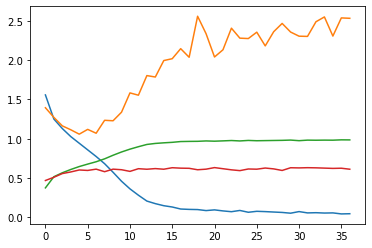

In [10]:
plt.plot(hist)

In [11]:
best_acc

0.633278508981069